<a href="https://colab.research.google.com/github/Eucalyptusss/Stock_News_NLP/blob/main/stock_news_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [136]:
!pip install colab-env --upgrade
!pip install fmpsdk
import colab_env
import pandas as pd
from collections import Counter
import nltk
import os
from dotenv import load_dotenv
from datetime import datetime, timedelta
from sklearn.metrics import (recall_score, accuracy_score, precision_score, 
                             classification_report)
import typing
import fmpsdk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
apikey = 'eb96eccac2f06f6735f3b5597486f833'
nltk.download('vader_lexicon')
import matplotlib.pyplot as plt
import numpy as np
from pylab import rcParams
import random
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import (train_test_split, cross_val_score, 
                            cross_validate, GridSearchCV, RandomizedSearchCV )

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, GRU
from keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import Precision
import random
from xgboost import XGBRFClassifier, XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
#!pip install ktrain
import ktrain
from ktrain import text

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Business Problem
Predicting a stock price is one of the most difficult problems companies are tackling in the machine learning realm. The difficulty is likely because a stock price is determined by the quantity available on the market, i.e. a supply and demand situation. This means that what moves a stock price is the amount of stock units being bought or sold at any given time. If more stocks are being purchased than sold then the existing stock units will increase in price. Stocks are being traded by individuals, stock brokers, hedge funds, entire corporations, and even governments. The amount of variables that determing a stock price make it much more difficult to capture the necessary training data.

# Business Understanding
This leads to my initial proposal of predicting stock price by analyzing a given stock's news headlines/articles. If stock's are determined by how many stocks are being bought or sold then the stock price will have a relationship to public sentiment regarding that stock. This is even more true in the 21st century. By that I mean in the 21st century the people actively trading stocks has shifted strongly in the direction of the general public. Summed up, this is due to being in the age of information. Previously, stocks were traded exclusively by insiders or people with some form of connection to the market. Now, anyone with internet access and a bank account can invest. Using stock news to predict the stock's gain/loss for a given day will surely not be the only metric needed to predict, but investigating how precise the following models are could prove to be well worth it.

# Obtain & Construct
## I will be using the following functions to construct a dataframe from the FMP Cloud API. The Function will take as parameters an apikey, stock ticker, and an integer limit. Please refer to the documentation within the vader_sentiment_analysis function.

In [137]:
def vader_sentiment_analysis(apikey, ticker, limit=5000):
    """
    IN: 
    apikey: This should be your personalized api key. You can get one here 
    (https://fmpcloud.io/)

    ticker: This is the stock symbol as or trade name. e.g. TSLA, AAPL, GOOG

    limit: This number references how far back in date you want to go. If you
    want to find the date range please use get_timeframe() on this method's returned df.
    
    OUT: Pandas Dataframe
    """
    #Initialize the sentiment analyzer
    sid = SentimentIntensityAnalyzer()
    #Collect the data from the fmpsdk api
    news = fmpsdk.stock_news(apikey=apikey, tickers=ticker, limit=limit)
    #Construct the dataframe with predtermined columns
    df = pd.DataFrame(columns=['Date', 'Title', 'Text', 'CompoundScoreTitle',
                          'PositiveScoreTitle', 'NegativeScoreTitle', 
                          'CompoundScoreText', 'NeutralScoreTitle',
                           'NeutralScoreText', 'textLeans', 'titleLeans',
                          'PositiveScoreText', 'NegativeScoreText',
                          'CompoundAvg', 'Symbol'])
    
    dates = []
    titles = []
    text_ = []
    symbols = []


    #Loops through the news variable which contains the data from the api. For 
    #loop the lists dates, titles, & text_ get appended so that the df above can
    #then have three columns with data
    for article in news:
        dates.append(article['publishedDate'])
        titles.append(article['title'])
        text_.append(article['text']) 
        symbols.append(article['symbol'])
    df.Date = pd.to_datetime(dates)
    df.Title = titles
    df.Text = text_
    df.Symbol = symbols
    
    #Removes None values from text that can appear
    df.Text = df.Text.apply(lambda txt: txt if txt != None else('Blank'))
    #Scores the title of the articles using compound score
    df.CompoundScoreTitle = df.Title.apply(lambda title:
    sid.polarity_scores(title)['compound'])
    #Scores the title of the articles using positive score
    df.PositiveScoreTitle = df.Title.apply(lambda title:
        sid.polarity_scores(title)['pos'])
    #Scores the title of the articles using negative score
    df.NegativeScoreTitle = df.Title.apply(lambda title:
        sid.polarity_scores(title)['neg'])
    #Scores the title of the articles using neutral score
    df.NeutralScoreTitle = df.Title.apply(lambda title:
        sid.polarity_scores(title)['neu'])
    #Scores the text of the articles using compound score
    df.CompoundScoreText = df.Text.apply(lambda text:
        sid.polarity_scores(text)['compound'])
    #Scores the text of the articles using positive score
    df.PositiveScoreText = df.Text.apply(lambda text:
        sid.polarity_scores(text)['pos'])
    #Scores the text of the articles using negative score
    df.NegativeScoreText = df.Text.apply(lambda text:
        sid.polarity_scores(text)['neg'])
    #Scores the text of the articles using neutral score
    df.NeutralScoreText = df.Text.apply(lambda text:
        sid.polarity_scores(text)['neu'])
    
    #I will now add two columns to the dataframe that will tell me which way the
    #sentiment analyzer is leaning in regards to tile and text. I will be using
    #the comound score here because it is the best representation of positve/neutral
    #& negative scores.

    #If the title comound score is less than 0 I determine that the title leans negative
    #if the comound score is greater than 0 I dettermine that the title leans
    #positive. Otherwise neutral.
    df.titleLeans = df.CompoundScoreTitle.apply(lambda score:
                    'Negative' if score < 0 
                     else('Positive' if score > 0
                          else('Neutral')))
                        
    df.textLeans = df.CompoundScoreText.apply(lambda score:
                        'Negative' if score < 0 
                         else('Positive' if score > 0
                              else('Neutral')))
    #Now I will add the day of the week
    #Days of the week are numberd 0-6 where 0 is Monday
    df['weekday'] = df.Date.apply(lambda date:
                                  date.weekday())
    #The time corresponding with the date will also need to in it's own column
    #for later processing
    df['time'] = df.Date.apply(lambda date:
                               date.time())
    #Finally I add the average of the comound scores for the title and text of a 
    #given article
    df.CompoundAvg = (df.CompoundScoreTitle + df.CompoundScoreText)/2
    
    return df 


In [155]:
syms = get_random_symbols(apikey)
df = vader_sentiment_analysis(apikey=apikey, ticker=syms, limit=10_000)

# Scrub
### To make this data more usable and interpretable I will make a function that will trim the data based on date & time. These metrics are important because news that comes out after the stock market is closed will affect the stock market the next day. The stock market is open from 9:30 AM - 4:00 pm Eastern Time. This means that the news data I will train my model on will be based on news from 4:00 pm on the previous day to 4:00 pm on the current day. e.g predictng AAPL stock gain/loss on 10-17-2021 will include news articles in the 24 hour range 10-16-2020 16:00:00 ----- 10-17-2021 16:00:00. However, the model will also contain the opening price for the day so we cannot predict until the market has opened for the day.

### I also need to deal with the fact that the method for obtaining the stock data only allows a limit number. This means there is no convenient way of determing what the date range of the initial dataframe is. So, I will construct a function that returns the date range of a proveded dataframe.

In [139]:
def trim_news_dates(stock_prediction_day, df):
  """
  This function will trim a provided dataframe to only contain dates relevant to
  the stock_prediction_day.

  IN: 
   - stock_prediction_day: This is the date that one would like to predict a 
   stocks gain/loss should be a string in the form 'YYYY-MM-DD'
   - df: This is the data frame that will be trimmed and returned only contaning
   dates relavant to the prediction
  """

  #Set start_cutoff to one day before stock_prediction_day at 4:00 PM as
  #a pandas datetime object
  end_cutoff = pd.to_datetime(stock_prediction_day + ' 16:00:00')
  start_cutoff = end_cutoff - timedelta(days=1)
  
  return df.loc[(df.Date >= start_cutoff) &
       (df.Date <= end_cutoff)]




In [140]:
def determine_date_range(df):
  """
  IN: pandas data frame that you would like to know the date range of
  OUT: Date range in pandas.datetime format
  """
  end_date = df.Date[0]
  start_date = df.Date[df.shape[0]-1]
  return (start_date, end_date)

# Baseline Model Construction
### To start I will not be using any advanced machine learning algorithms to construct my baseline predictor model. I will be using the VADER sentiment scores as the baseline predictor. That is, if the average comound score is > 0 we will predict a gain, if the average comound score < 0 we will predict loss, if the average compound score is 0 we will determine there is not enough data for a prediction.
### Because there are possibly more than 1 news article within a stock day the prediction will be based on the whether or not there are more gain predictions or more loss predictions.
### To build and analyze this model I will take the following steps
 - Add a prediction column to our dataframe based on comound average
 - Get actual stock gains & losses and add them to the data frame
 - Determine accuracy, precision, and recall scores for the vader tool based on actual gains/losses of the the stocks:
 



In [156]:
vader_df = vader_sentiment_analysis(apikey=apikey, ticker=syms, limit=10_000)

#### For later computation I will be adding the prediction metric as either 1 (gain), 0 (not enough data), or -1 (loss).


In [157]:
vader_df['Prediction'] = vader_df.CompoundAvg.apply(lambda avg:
                                                    1 if avg > 0
                                                    else( -1 if avg < 0
                                                         else(0)))


#### Now I will add a stock's actual gain/loss by acessing the fmp api again

In [143]:
def get_stock_data(ticker, from_date, to_date):
    """
    IN:   
      ticker: stock symbol e.g. AAPL
      from_date: starting date when obtaining stock historical price
      to_date: ending date when obtaining stock historical price

    OUT:
      df : Pandas dataframe containg the provided stock' historical price and other
      metrics within the provided time range
  
    """
    newDF = pd.DataFrame() #creates a new dataframe that's empty
    for tick in ticker:
      stock_dict = fmpsdk.historical_price_full(apikey=apikey, symbol=tick, from_date=from_date,
                                         to_date=to_date)
      df = pd.DataFrame(stock_dict,columns=list(stock_dict[0].keys()))
      df.date = pd.to_datetime(df.date)
      df['Symbol'] = tick
      newDF = newDF.append(df)
    newDF.sort_values('date', ascending=False, inplace=True)
    return newDF

In [158]:
frm = str(determine_date_range(vader_df)[0])[0:10]
to = str(determine_date_range(vader_df)[1])[0:10]

stock_train_data = get_stock_data(syms, frm, to)

#### Now, I will need to combine the data. I will take the following steps to achieve this:
- Since it's probable that there are more than one articles being published regarding a stock in a given 24 hour range, I will use the average of the  ComoundAvgScores for a given 24 hour range. 
- To achieve this, I will add an identifier to the vader_df that has the corresponding date that we will want to predict
- e.g. news withing the range 2021-10-13 16:00:00 --- 2021-10-14 16:00:00 will correspond to the stock on 2021-20-14
- I also will consider from Friday 16:00:00 --- Monday 16:00:00 as one 24 hour range because the stock market is only open M-F
- Once I have determined a predictiton for a range I will add the prediction to the stock_train_data


In [159]:
#The new boolean column is_weekend_data will be true if the date falls in the range
#Friday 16:00:00 - Sunday 24:00:00

vader_df['is_weekend_data'] = vader_df.apply(lambda col:
                              True if (
                              (col['weekday'] == 5) |
                              (col['weekday'] == 6) |
                              ((col['weekday'] == 4) &
                              (col['Date'].time() > pd.to_datetime('1999-01-16 16:00:00').time()))
)
                              else(False), axis=1
)


In [160]:
#Pseudocode to addd stock_prediction_day to vader_model_dataframe
# if is_weekend_data:
  #if friday
    #return day + 3 days
  #elif Saturday
    #return day + 2 days
  #elif sunday 
    #return day + 1 day
# else
  #if time >= 16:00:00 & time<=24:00:00
    #return day + 1
  #elif time >= 00:00:00 & time<16:00
    #return day

def add_stock_prediction_day(vader_df):
  cutoff_start = pd.to_datetime('1999-01-01 16:00:00')
  cutoff_end = pd.to_datetime('1999-01-01 23:00:00')
  vader_df['Stock_Prediction_Day'] = vader_df.apply(lambda row: 
               
    (row.Date+timedelta(days=3)).date()
    if ((row['is_weekend_data'] == True) & (row['weekday'] == 4))
    else(
        (row.Date + timedelta(days=2)).date()
        if ((row['is_weekend_data'] == True) & (row['weekday'] == 5))

    else(
        (row.Date + timedelta(days=1)).date()
        if ((row['is_weekend_data'] == True) & (row['weekday'] == 6))

    else(
        (row.Date + timedelta(days=1)).date() 
        if ((row['Date'].time() >= cutoff_start.time()) & (row['Date'].time() <= cutoff_end.time()))
    else(row.Date.date())))), axis=1)
  return vader_df


In [161]:
vader_df = add_stock_prediction_day(vader_df).copy()

#### Now that I have the corresponding stock prediction day I will add the stock prediction of for each stock prediction day. This will be based on the average predictions i.e. GAIN if n(1) < n(-1) LOSS if n(-1) > n(1) where n denotes frequency

In [148]:
def add_predictions_to_stock_pred_day(df):
  """
  IN:
    df : Pandas dataframe with vader sentiment analysis scores
  OUT:
    preds : Dictionary where keys are stock prediction dates and values are 
    a prediction of gain or loss

  """
  dates = list(df.Stock_Prediction_Day.value_counts().keys())
  preds = {}
  for date in dates:
    
    mode = df.loc[df.Stock_Prediction_Day == date].Prediction.mode()

    if (mode[0] == 1):
      preds[date] = 'gain'
    elif (mode[0]  == -1):
      preds[date] = 'loss'
    else:
      preds[date] = 'NotEnoughData'
  return preds
      




In [162]:
#Using the dictionary from above to map predictions from Stock_Prediction_Day
#to a new column final_prediction
vader_df['final_prediction'] = vader_df.Stock_Prediction_Day.map(add_predictions_to_stock_pred_day(vader_df))

#### Now I can then add a prediction column by mapping dates with the returned dict from add_predictions_to_stock_pred_day

In [163]:
#Doing the same but for the stock_train_data df
stock_train_data['vader_prediction'] = stock_train_data.date.map(add_predictions_to_stock_pred_day(vader_df))
stock_train_data.vader_prediction.fillna('NotEnoughData',inplace=True)

#### Now we can calculate accuracy, prediction, and recall. To do this I wil
- add a y_true column defined by change i.e. change > 0 = gain and  change < 0 = loss
- make a y_true list from df
- make a y_pred list from df 
- calculate scores

In [164]:
#Change is defined by Stock_Open - Stock_Close
stock_train_data['y_true'] = stock_train_data.change.apply(lambda change: 
                            'gain' if change > 0
                            else('loss' if change < 0
                            else('NotEnoughData')))


In [165]:
stock_train_data.y_true.value_counts()

gain             4169
loss             4100
NotEnoughData      31
Name: y_true, dtype: int64

In [168]:
#Make classification report for data
y_true = stock_train_data.y_true
y_pred = stock_train_data.vader_prediction
print(classification_report(y_true, y_pred, labels=y_pred.unique()))

               precision    recall  f1-score   support

         gain       0.51      0.52      0.51      4169
NotEnoughData       0.00      0.29      0.01        31
         loss       0.54      0.09      0.15      4100

     accuracy                           0.31      8300
    macro avg       0.35      0.30      0.22      8300
 weighted avg       0.52      0.31      0.33      8300



### The scores here are meaningful, but this data is only for these specific stocks and for a certain time range. I will now make the entire process aboved into a streamlined function so we can analyze this model further with additional stocks.

In [49]:
def build_vader_model(apikey, ticker, limit=5000):
  """
  IN:
    apikey : FMP Cloud apikey
    ticker : stock symbol e.g. GOOG
    limit : How far back we will get news articles. Note: A higher limit means
    a farther back date range.
  
  OUT:
    stock_train_data : Pandas dataframe containing stock information, actual
    stock gain/loss, and vader model prediction of stocks

    vader_df : Pandas dataframe containing news articles with vader sentiment
    scores, vader prediction, and corresponding stock_prediction day
  """
  #Builds vader dataframe with sentiment scores
  vader_df = vader_sentiment_analysis(apikey=apikey, ticker=ticker, limit=limit)
  # print('Your news time range is ')
  # print(determine_date_range(vader_df))
  #Adds prediction column to vader_df based on CompundAvg scores
  vader_df['Prediction'] = vader_df.CompoundAvg.apply(lambda avg:
                                                    1 if avg > 0
                                                    else( -1 if avg < 0
                                                         else(0)))
  #Determine date range of vader_df. Neccessary to build stock_train_data df
  frm = str(determine_date_range(vader_df)[0])[0:10]
  to = str(determine_date_range(vader_df)[1])[0:10]
  #Build stock_train_data df of a given stock within a specified time range
  stock_train_data = get_stock_data(ticker, frm, to)

  #Adds column to vader_df determining if the day is on a friday, saturday, or
  #sunday. 
  vader_df['is_weekend_data'] = vader_df.apply(lambda col:
                              True if (
                              (col['weekday'] == 5) |
                              (col['weekday'] == 6) |
                              ((col['weekday'] == 4) &
                              (col['Date'].time() > pd.to_datetime('1999-01-16 16:00:00').time()))
)
                              else(False), axis=1
)
  #The time ranges are the only importang thing here
  cutoff_start = pd.to_datetime('1999-01-01 16:00:00')
  cutoff_end = pd.to_datetime('1999-01-01 23:00:00')

  #Adds corresponding stock_prediction day to vader_dataframe. E.G. If news is coming
  #on a sunday then the corresponding stock day is the following monday
  vader_df['Stock_Prediction_Day'] = vader_df.apply(lambda row: 
                
      (row.Date+timedelta(days=3)).date()
      if ((row['is_weekend_data'] == True) & (row['weekday'] == 4))
      else(
          (row.Date + timedelta(days=2)).date()
          if ((row['is_weekend_data'] == True) & (row['weekday'] == 5))

      else(
          (row.Date + timedelta(days=1)).date()
          if ((row['is_weekend_data'] == True) & (row['weekday'] == 6))

      else(
          (row.Date + timedelta(days=1)).date() 
          if ((row['Date'].time() >= cutoff_start.time()) & (row['Date'].time() <= cutoff_end.time()))
      else(row.Date.date())))), axis=1)
  #Adds vader prediction to stock train data based on stock prediction day above
  stock_train_data['vader_prediction'] = stock_train_data.date.map(add_predictions_to_stock_pred_day(vader_df))
  stock_train_data.vader_prediction.fillna('NotEnoughData',inplace=True)

  #Adds actual stock gain or loss defined by stock change(Open price - Close price)
  stock_train_data['y_true'] = stock_train_data.change.apply(lambda change: 
                            'gain' if change > 0
                            else('loss' if change < 0
                            else('NotEnoughData')))
  # Fix class impalance. 
  #This is not neccessary for the vader model at this point.
  #stock_train_data = repair_class_imbalance(stock_train_data)

  #Changes date column to Date to match vader_df
  stock_train_data['Date'] = stock_train_data.date
  return (stock_train_data, vader_df)
  
  

  
def analyze_vader_model(stock_df, output=True):
  """
  IN: 
    stock_df : stock_train_data dataframe with vader_predictions
  OUT:
    classification_report dictionary: A dictionary containing the metrics
    for the predictions including precision, recall, f1, and accuracy
  """
  y_true = stock_df.y_true
  y_pred = stock_df.vader_prediction
  return(classification_report(y_true, y_pred, labels=y_true.unique(), 
                               output_dict=output))






# Baseline Model Evaluation
#### The model will perform differently based on the individual stock. The prediction is relavant to if their is recent news. Therefore, I will randomly compile a list of stock symbols recently appearing in news from the fmp api. To increase the chances of the stock being news worthy I will be pulling form teh S&P top 500 companies.

In [50]:
def get_random_symbols(apikey, list_limit=10):
  """
  IN: 
    apikey : FMP cloud apikey
    list_limit : The number of symbols you would like to return

  OUT: 
    randoms : List of random symbols of length list_limit
  """
  import random
  news_dict = fmpsdk.sp500_constituent(apikey=apikey)
  symbols = []
  randoms = []
  for element in news_dict:
    symbols.append(element['symbol'])
    
  for i in range(list_limit):
    randoms.append(random.choice(symbols))
  return randoms


In [51]:
#Get 10 random stock symbols
symbols = get_random_symbols(apikey)
#Initialize 6 lists corresponding to metric scores
df = build_vader_model(apikey, symbols)[0]
#Get classification report for vader model
r_baseline = analyze_vader_model(df, output=False)
r_baseline_plot = analyze_vader_model(df, output=True)




In [52]:
def plot_classification_report(report, title, labels = str):
  if labels == str:
    gain_f1 = (report['gain']['f1-score'])
    gain_precision = (report['gain']['precision'])
    gain_recall = (report['gain']['recall'])
    
    loss_f1 = report['loss']['f1-score']
    loss_precision = report['loss']['precision']
    loss_recall = report['loss']['recall']
  else:
    gain_f1 = (report['1']['f1-score'])
    gain_precision = (report['1']['precision'])
    gain_recall = (report['1']['recall'])

    loss_f1 = report['0']['f1-score']
    loss_precision = report['0']['precision']
    loss_recall = report['0']['recall']


  plt.figure(figsize=(10,7))
  objects = ('Gain_F1', 'Gain_Precision', 'Gain_Recall', 'Loss_F1', 'Loss_Precision',
      'Loss_Recall')
  y_pos = np.arange(len(objects))
  performance = [gain_f1, gain_precision, gain_recall, loss_f1, loss_precision, loss_recall]

  plt.bar(y_pos, performance, align='center', alpha=0.5)
  plt.xticks(y_pos, objects)
  plt.xlabel('Model Metrics')
  plt.ylabel('Metric Score')
  plt.title(title)
  

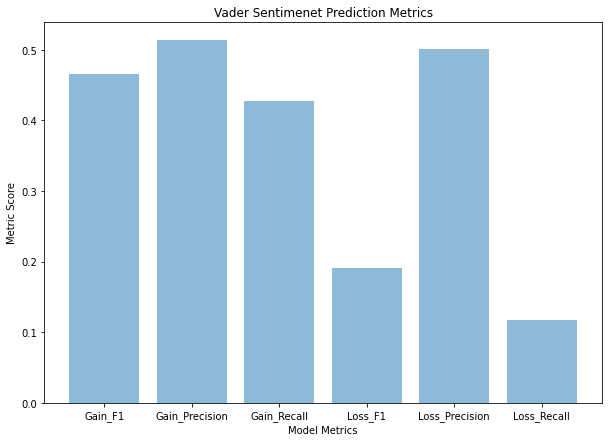

In [53]:
plot_classification_report(r_baseline_plot, 'Vader Sentimenet Prediction Metrics')

# Baseline Model Analysis 
The model performed better than expected. The very clear strength here is our loss precision and gain precision.  However, the loss recall is still very low and so is gain reccall. To achieve the most value from this project I need to have an impressive precision for gain & loss but also account for recall. A strenght of this model is that I do not need to account for class imbalance. 

# Basline Model with Machine Learning
#### I will now build a model using a very similar methodolgy as above. This model will use machine learning to predict stock prices based on the individual sentiment scores.




In [54]:
randoms = get_random_symbols(apikey, 10)
stock_df, vader_df = build_vader_model(apikey, randoms, limit=5000)

In [55]:
def add_y_true(stock_df):
  """
  IN:
    stock_df : this should be the stock_train_data returned from the build_vader_model
  OUT:
    y_trues: Dictionary containing dates with corresponding actual stock gain or loss
  """

  dates = list(stock_df.date)
  y_trues = {}
  for date in dates:
    y_trues[date] = stock_df.loc[stock_df.date == date].y_true
 
  return y_trues


In [56]:
data = add_y_true(stock_df)
vader_df['y_true'] = vader_df.Stock_Prediction_Day.map(data)
vader_df.dropna(inplace=True)
vader_df['y_true'] = vader_df.y_true.apply(lambda val:
                         'gain'if 'g'in str(val)[5:7]
                         else('loss'))

vader_df.reset_index(drop=True, inplace=True)

## EDA
#### There are some possible relationships that I would like to explore. First, I will look into how the quantity of news being published regarding a stock affect stock price.

#### I will now plot each symbol in vadeer_df in a scatter plot that compares quantity of news articles to open_price over time. First I need to add the open price to the vader_df above. I will do this in the following steps:
- Add a column to each data frame that is a string combination of date and symbol
- Loop through the new column in the stock_df adding to a dictionary where the key is the symbol+date and the value is the open price
- Add an open column to the vader_df by mapping the symbol+date column to the dictionary from the stock_df
- Add a column to vader_df denoting the frequency of news objects per date & symbol
- Plot a time series from the start date with each stock open's as a line

In [57]:
vader_df['sym+date'] = vader_df.Stock_Prediction_Day.astype(str) + vader_df.Symbol
stock_df['sym+date'] = stock_df.Date.astype(str) + stock_df.Symbol

In [58]:
stock_df['open_p'] = stock_df.open
stock_df.drop(columns='open',inplace=True)

In [59]:
final_dict = {}
for element in stock_df['sym+date']:
  open_p = stock_df.loc[stock_df['sym+date'] == element].open_p.astype(float).mean()
  final_dict[element] = open_p



In [60]:
vader_df['Open_Price'] = vader_df['sym+date'].map(final_dict)

In [61]:
analysis_df = vader_df[['Open_Price', 'Title', 'Stock_Prediction_Day', 'Text',
                        'Symbol','sym+date']].copy()

In [62]:
analysis_df['Number_of_Articles_Today'] = analysis_df['sym+date'].apply(
    lambda day: len(analysis_df.loc[analysis_df['sym+date']==day].Title)
)
analysis_df.drop(columns=['Title', 'Text'], inplace=True)


#### Before plotting I will standardize the Open_Price and Number_of_Articles_Today so that they are on the same scale.

In [63]:
dates = list(analysis_df.Stock_Prediction_Day.unique())

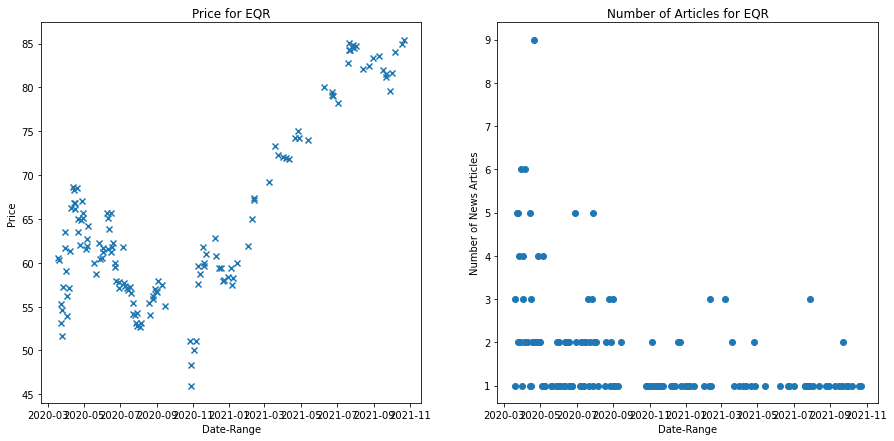

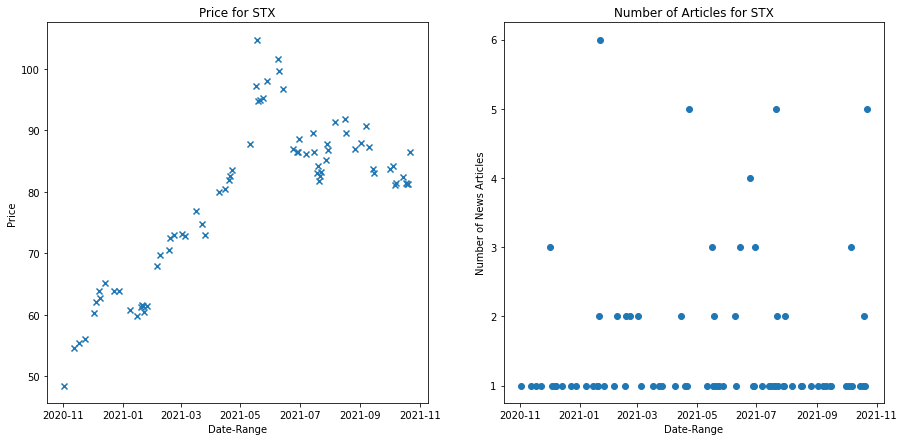

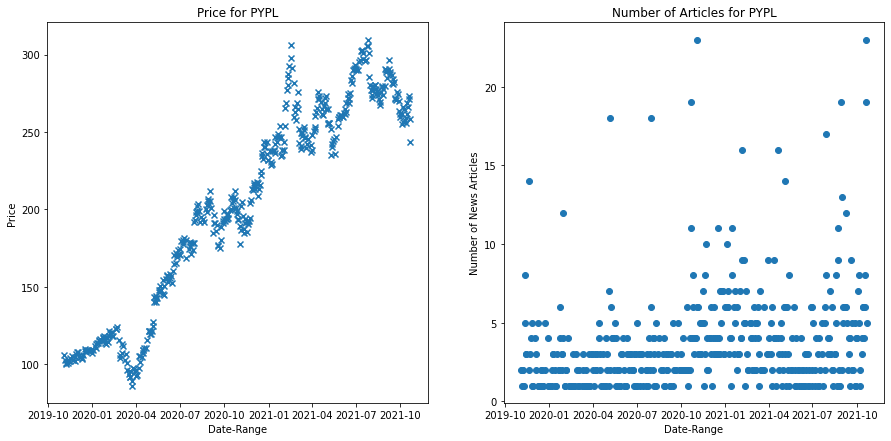

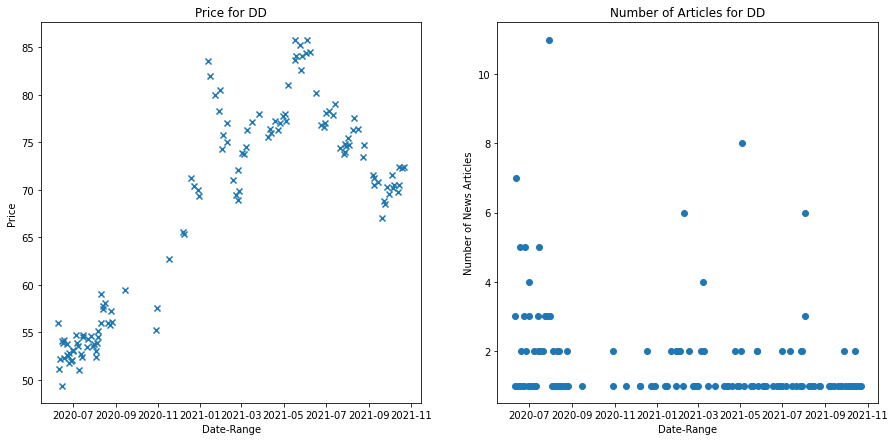

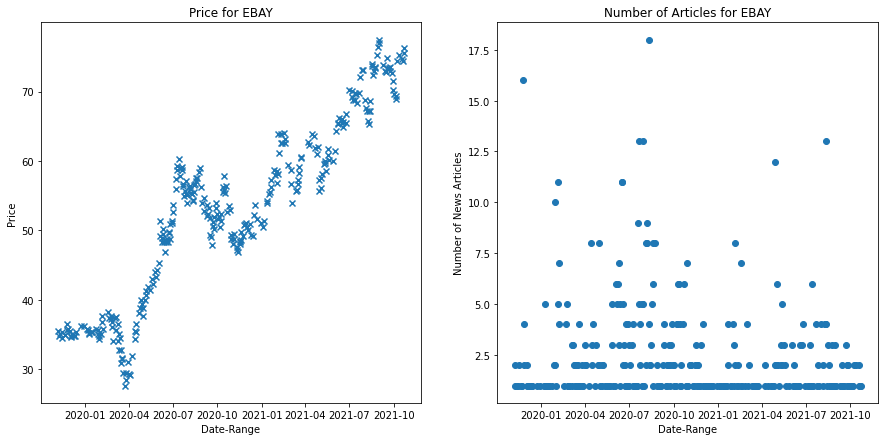

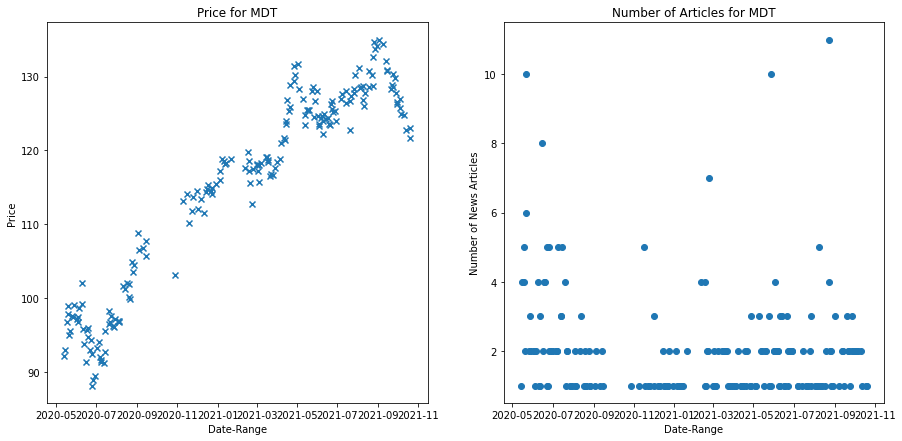

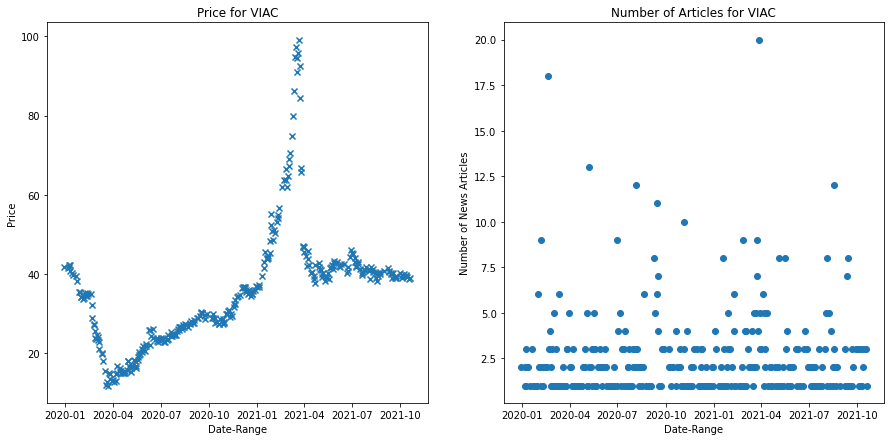

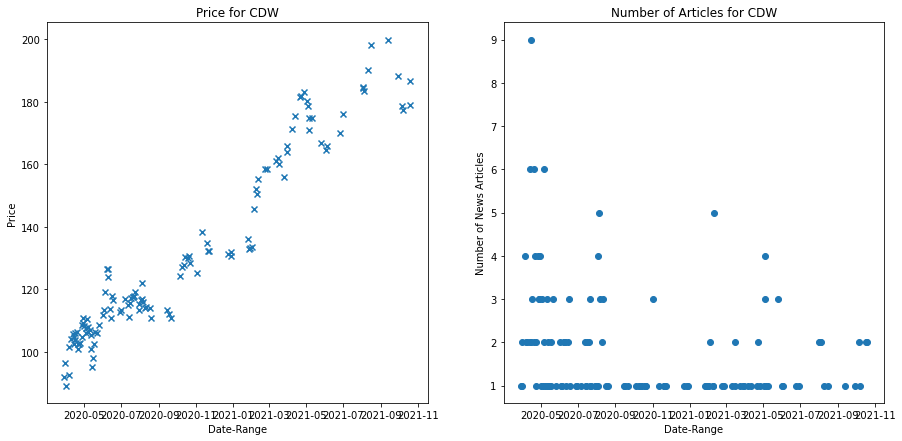

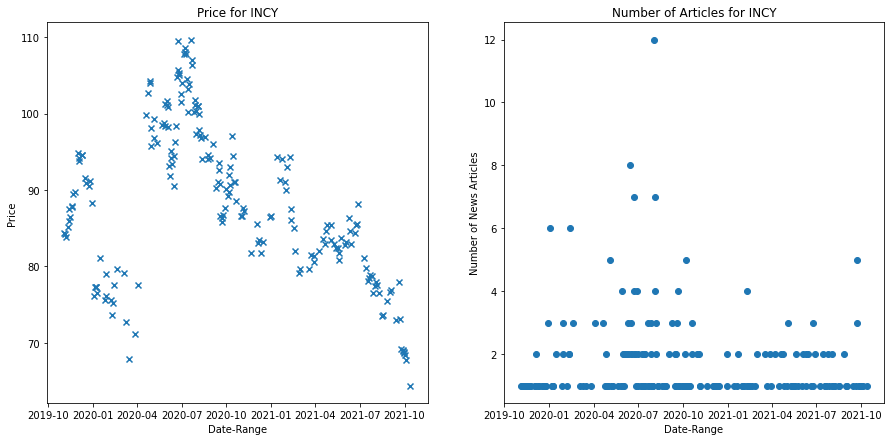

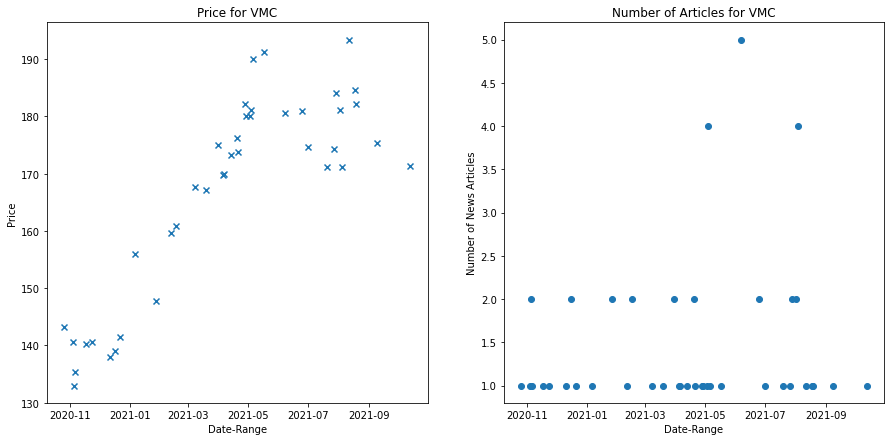

In [64]:
x = dates
for sym in analysis_df.Symbol.unique():
  plt.figure(figsize=(15,7))
  plt.subplot(1, 2, 1)
  y_open = []
  num_news = []
  for date in dates:
    open_p = analysis_df.loc[(analysis_df.Stock_Prediction_Day==date)&
                           (analysis_df.Symbol==sym)].Open_Price.mean()

    n = analysis_df.loc[(analysis_df.Stock_Prediction_Day==date)&
                           (analysis_df.Symbol==sym)].Number_of_Articles_Today.mean()
    y_open.append(open_p)
    num_news.append(n)
  
  plt.scatter(x, y_open, label=sym+' Open Price', marker='x')
  plt.title('Price for '+sym)
  plt.ylabel('Price')
  plt.xlabel('Date-Range')
  plt.subplot(1, 2, 2)
  plt.scatter(x, num_news, label=sym+' Number of News Articles')
  plt.title('Number of Articles for '+sym)
  plt.xlabel('Date-Range')
  plt.ylabel('Number of News Articles')


  


#### It does not appear that their is a relationship between the amount of publicity a company gets and their growth. The visualizationa above do a good job showing the limitations of our training data. You can see that if there is not news for a stock in a certain timeframe then the stock price is missing as well. This is intentional. The scope of the project is the relationship between the news and a stock price.

## Train Test Split

In [65]:
X = vader_df[['NegativeScoreText', 'CompoundAvg', 'CompoundScoreTitle', 'PositiveScoreTitle',
              'NegativeScoreTitle', 'CompoundScoreText', 'NeutralScoreTitle', 'NeutralScoreText',
              'PositiveScoreText']]
y = vader_df['y_true']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=24)

## Scale

In [66]:
sc = StandardScaler()
X_train_scaled = pd.DataFrame(sc.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(sc.transform(X_test), columns = X_test.columns)


## Class Imbalance
#### As of right now, I am seeing consistently more loss days than gains. This makes sense considering the affect of the global pandemic. I will weight the losses.
wj=n_samples / (n_classes * n_samplesj)

In [67]:
l = y_train.value_counts()['loss']
g = y_train.value_counts()['gain']
l, g

(2999, 277)

In [68]:
weight = l / g
weight

10.826714801444043

## Binary Encoding

In [69]:
y_test = y_test.apply(lambda el: 1 if el == 'gain' else(0))
y_train = y_train.apply(lambda el: 1 if el == 'gain' else(0))

## XGBOOST MODEL with Vader Sentiment Scores

In [70]:
van_xg = XGBClassifier(scale_pos_weight=(weight))
van_xg.fit(X_train_scaled, y_train)

XGBClassifier(scale_pos_weight=10.826714801444043)

In [71]:
van_report = classification_report(y_test, van_xg.predict(X_test), 
                                output_dict=False)
print(van_report)

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1467
           1       0.17      0.14      0.15       148

    accuracy                           0.86      1615
   macro avg       0.54      0.53      0.54      1615
weighted avg       0.85      0.86      0.85      1615



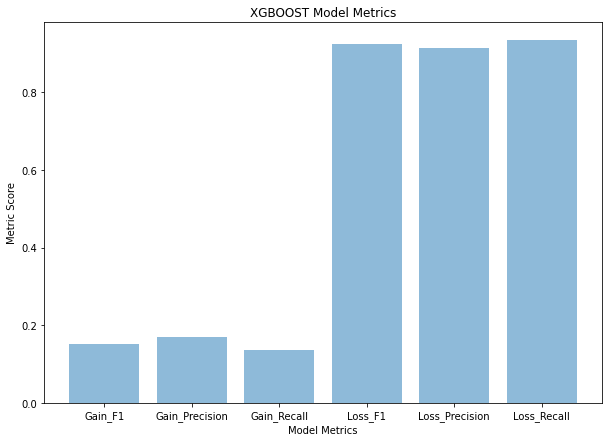

In [72]:
plot_classification_report(classification_report(y_test, van_xg.predict(X_test), 
                                output_dict=True), 'XGBOOST Model Metrics',
                           labels=int)

### Parameter Optimization

In [73]:
parameters = {
    'max_depth': range (0, 10, 2),
    'n_estimators': range (90, 110, 2),
    'learning_rate':  np.linspace(.01, .1, 5) , 
    'scale_pos_weight': [weight-1,weight+1,weight-.5,weight+.5, weight-.25,
                         weight+.25] 
}
xg = XGBClassifier()

In [74]:
grid_search = GridSearchCV(
    estimator=xg,
    param_grid=parameters,
    scoring = 'precision',
    n_jobs = 10,
    cv = 3,
    verbose=True
)

In [77]:
grid_search.fit(X_train_scaled, y_train )

Fitting 3 folds for each of 1500 candidates, totalling 4500 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    8.8s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   17.5s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   41.2s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:  1.7min
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:  2.6min
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:  4.2min
[Parallel(n_jobs=10)]: Done 2430 tasks      | elapsed:  5.3min
[Parallel(n_jobs=10)]: Done 3180 tasks      | elapsed:  6.9min
[Parallel(n_jobs=10)]: Done 4030 tasks      | elapsed:  8.9min
[Parallel(n_jobs=10)]: Done 4500 out of 4500 | elapsed: 10.4min finished


GridSearchCV(cv=3, estimator=XGBClassifier(), n_jobs=10,
             param_grid={'learning_rate': array([0.01  , 0.0325, 0.055 , 0.0775, 0.1   ]),
                         'max_depth': range(0, 10, 2),
                         'n_estimators': range(90, 110, 2),
                         'scale_pos_weight': [9.826714801444043,
                                              11.826714801444043,
                                              10.326714801444043,
                                              11.326714801444043,
                                              10.576714801444043,
                                              11.076714801444043]},
             scoring='precision', verbose=True)

In [78]:
grid_search.best_params_

{'learning_rate': 0.0775,
 'max_depth': 4,
 'n_estimators': 108,
 'scale_pos_weight': 9.826714801444043}

In [79]:
xg = XGBClassifier(**grid_search.best_params_)
xg.fit(X_train_scaled, y_train)

XGBClassifier(learning_rate=0.0775, max_depth=4, n_estimators=108,
              scale_pos_weight=9.826714801444043)

In [80]:
op_report = classification_report(y_test, xg.predict(X_test), 
                                output_dict=False)
print(op_report)

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1467
           1       0.10      0.13      0.11       148

    accuracy                           0.82      1615
   macro avg       0.51      0.51      0.51      1615
weighted avg       0.84      0.82      0.83      1615



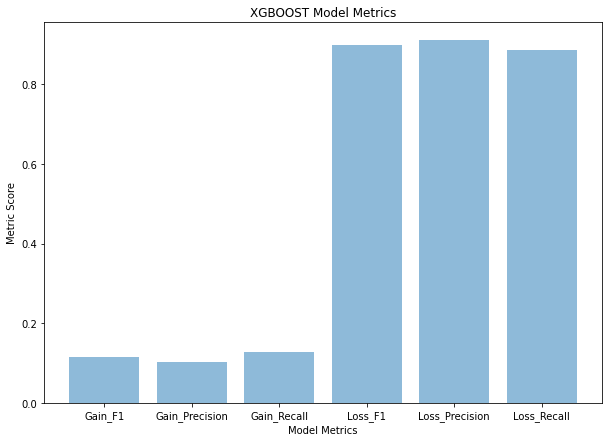

In [81]:
plot_classification_report(classification_report(y_test, xg.predict(X_test), 
                                output_dict=True), 'XGBOOST Model Metrics',
                           labels=int)

### Comparison of Optimized vs Vanilla
#### Optimized


In [82]:
print(op_report)

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1467
           1       0.10      0.13      0.11       148

    accuracy                           0.82      1615
   macro avg       0.51      0.51      0.51      1615
weighted avg       0.84      0.82      0.83      1615



#### Vanilla

In [83]:
print(van_report)

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1467
           1       0.17      0.14      0.15       148

    accuracy                           0.86      1615
   macro avg       0.54      0.53      0.54      1615
weighted avg       0.85      0.86      0.85      1615



## XGBOOST Analysis 
#### It may be valuable to derive what sentiment scores provide the most valuable information. Below I will inspect the most important features.

In [84]:
importance_df = pd.DataFrame(xg.feature_importances_, columns=['importance'])
importance_df['feature_name'] = X_train_scaled.columns

In [85]:
importance_df.sort_values('importance', ascending=False)

,importance,feature_name
4,0.138214,NegativeScoreTitle
5,0.125640,CompoundScoreText
6,0.122056,NeutralScoreTitle
7,0.111498,NeutralScoreText
0,0.108957,NegativeScoreText
8,0.105273,PositiveScoreText
1,0.103901,CompoundAvg
2,0.100916,CompoundScoreTitle
3,0.083545,PositiveScoreTitle


#### Feature Importances Analysis 
The CompoundScore for the text being the highest is a very important fact. This means that model is getting most of it's information from the text of article. This means that the vader sentiment scores are valuable regarding the body of a stock news article. The second highest feature is the negative score of the title. This is not suprising because negative headlines tend to have more impact on human decisions than positive ones. 

# Recurrent Neural Network 
## The next model I will use is a recurrent neural network. The construction of this model will happen in the following high level steps:
 - Prepare train & test data
 - Construct the model

In [86]:
import random
random = get_random_symbols(apikey, 15)
stock_df, df = build_vader_model(apikey, random, limit=9500)

In [87]:
stock_df['Date'] = stock_df.date

#### First, I will need to get a list of the y_trues from the stock_train_data

In [88]:
#Dictionary containing dates with corresponding actual stock gain or loss
data = add_y_true(stock_df)

In [89]:
#Adds y_true to vader_df from dictionary data made above
vader_df['y_true'] = vader_df.Stock_Prediction_Day.map(data)
vader_df.dropna(inplace=True)
vader_df['y_true'] = vader_df.y_true.apply(lambda val:
                         'gain'if 'g'in str(val)[5:7]
                         else('loss'))

vader_df.reset_index(drop=True, inplace=True)

In [90]:
def combine_text_title(df):
  """
  IN: df : This should be the vader model dataframe with text and title columns
  OUT: df : Same df inputted but with the new column final_text that is the title
  and text combined
  """
  df['final_text'] = df.Title + df.Text
  return df

In [91]:
vader_df = combine_text_title(vader_df).copy()

#### Preparing NLP

In [92]:
# Count unique words
def counter_word(text_):
    count = Counter()
    for i in text_.values:
        for word in i.split():
            count[word] += 1
    return count

In [93]:
text_ = vader_df.final_text
counter = counter_word(text_)
num_words = len(counter)
max_length = 90

# Train Test Split

In [94]:
recurrent_df = vader_df[['final_text', 'y_true']].copy()

In [95]:
seed = 24

X = recurrent_df['final_text']
test_size = int(np.round(X.shape[0] * .15))
y = recurrent_df['y_true']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, 
                                                    random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=test_size, random_state=seed)

print(f'Train:\n\tX: {X_train.shape}\n\ty: {y_train.shape}')
print(f'Test:\n\tX: {X_test.shape}\n\ty: {y_test.shape}')
print(f'Val:\n\tX: {X_val.shape}\n\ty: {y_val.shape}')

Train:
	X: (2125,)
	y: (2125,)
Test:
	X: (455,)
	y: (455,)
Val:
	X: (455,)
	y: (455,)


# Binary Encoding

In [96]:
y_test = y_test.apply(lambda el: 1 if el == 'gain' else(0))
y_train = y_train.apply(lambda el: 1 if el == 'gain' else(0))
y_val = y_val.apply(lambda el: 1 if el == 'gain' else(0))

## NLP

In [97]:
#TOKENIZE
#Removes Puncuation
tokenizer = Tokenizer(num_words=num_words, filters=('–', '/'))
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
#Sequencing
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(
    train_sequences, maxlen=max_length, padding="post", truncating="post"
)
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(
    test_sequences, maxlen=max_length, padding="post", truncating="post"
)
val_sequences = tokenizer.texts_to_sequences(X_val)
val_padded = pad_sequences(
    val_sequences, maxlen=max_length, padding="post", truncating="post"
)


## Word Embeddings using Glove

In [99]:
glove_vecs = {}
file = open('/content/drive/MyDrive/glove/glove.6B.50d.txt',
            encoding='utf-8')
for line in file:
  values = line.split()
  word = values[0]
  vectors = np.asarray(values[1:])
  glove_vecs[word] = vectors
file.close()

word_vector_matrix = np.zeros((num_words, 50))
for word, idx in tokenizer.word_index.items():
  vector = glove_vecs.get(word)
  if vector is not None:
    word_vector_matrix[idx] = vector


In [100]:
len(glove_vecs.keys())

400001

In [101]:
vec_size = 50

## Model Construction

In [102]:
model = Sequential()
model.add(Embedding(num_words, vec_size, input_length=max_length,
                    weights = [word_vector_matrix], trainable = False))
model.add(GRU(64, kernel_regularizer=regularizers.l2()))

model.add(layers.Dense(128, activation='tanh'))
model.add(Dense(1, activation="sigmoid"))
optimizer = Adam(learning_rate=3e-4)



model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])



In [103]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train), y_train)                                              
weights_sk = {
    0: class_weights[0],
    1: class_weights[1]
}
l = y_train.value_counts()[0]
g = y_train.value_counts()[1]
                                              
weights = {
    0: ((g/l)+weights_sk[0])/2,
    1: ((l/g)+weights_sk[1])/2
}

In [104]:
weights

{0: 0.40348639455782315, 1: 3.9148199445983383}

In [105]:
#Train Model
history = model.fit(
    train_padded, y_train, epochs=150, validation_data=(test_padded, y_test),
    callbacks=[EarlyStopping(patience=20, restore_best_weights=True)],
    class_weight=weights_sk
)

Epoch 1/150
67/67 [==============================] - 7s 29ms/step - loss: 1.3520 - accuracy: 0.8085 - val_loss: 1.2288 - val_accuracy: 0.8396
Epoch 2/150
67/67 [==============================] - 1s 21ms/step - loss: 1.1380 - accuracy: 0.8118 - val_loss: 1.0462 - val_accuracy: 0.8396
Epoch 3/150
67/67 [==============================] - 1s 21ms/step - loss: 0.9894 - accuracy: 0.8118 - val_loss: 0.9197 - val_accuracy: 0.8396
Epoch 4/150
67/67 [==============================] - 1s 22ms/step - loss: 0.8870 - accuracy: 0.8094 - val_loss: 0.8432 - val_accuracy: 0.8330
Epoch 5/150
67/67 [==============================] - 1s 21ms/step - loss: 0.8177 - accuracy: 0.8141 - val_loss: 0.7916 - val_accuracy: 0.8286
Epoch 6/150
67/67 [==============================] - 1s 21ms/step - loss: 0.7709 - accuracy: 0.8075 - val_loss: 0.7529 - val_accuracy: 0.8286
Epoch 7/150
67/67 [==============================] - 1s 22ms/step - loss: 0.7403 - accuracy: 0.8089 - val_loss: 0.7318 - val_accuracy: 0.8264
Epoch 

In [106]:
y_pred_probs = model.predict(val_padded)
y_pred = []
for y in y_pred_probs:
  if y > .5:
    y_pred.append(1)
  else:
    y_pred.append(0)

r_gru = classification_report(y_val, y_pred, output_dict=False)
r_gru_plot = classification_report(y_val, y_pred, output_dict=True)

In [107]:
print(r_gru)

              precision    recall  f1-score   support

           0       0.82      0.98      0.89       375
           1       0.18      0.03      0.04        80

    accuracy                           0.81       455
   macro avg       0.50      0.50      0.47       455
weighted avg       0.71      0.81      0.74       455



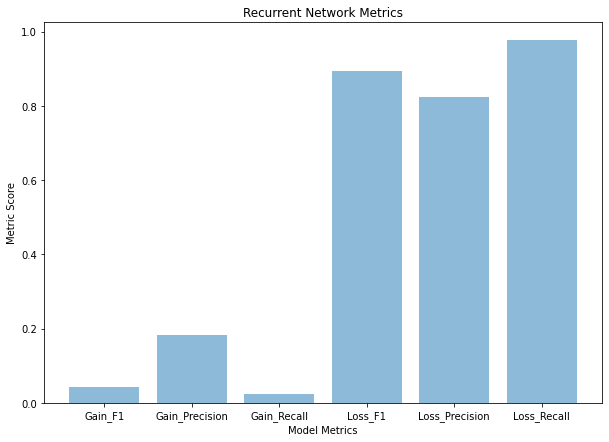

In [108]:
plot_classification_report(r_gru_plot, 'Recurrent Network Metrics', labels=int)

In [109]:
def plot_history(history, style=['ggplot', 'seaborn-talk']):
    """
    SOURCE: Claude Fried (https://www.linkedin.com/in/claude-fried/)
    Plot history from History object (or history dict) 
    once Tensorflow model is trained.
    
    Parameters:
    -----------
    history:
        History object returned from a model.fit()
    style: string or list of strings (default: ['ggplot', 'seaborn-talk'])
        Style from matplotlib.
    """
    
    # We can pass in a model history object or a dictionary.
    if not isinstance(history, dict): # We prefer this type of check over `if type() == ...`
        history = history.history

    metrics_lst = [m for m in history.keys() if not m.startswith('val')]
    N = len(metrics_lst)
    with plt.style.context(style):
        fig, ax_lst = plt.subplots(nrows=N, figsize=(8, 4*(N)))
        ax_lst = [ax_lst] if N == 1 else ax_lst.flatten() # Flatten ax_lst.
        for metric, ax in zip(metrics_lst, ax_lst):
            val_m = f'val_{metric}'
            ax.plot(history[metric], label=metric)
            ax.plot(history[val_m], label=val_m)
            ax.set(title=metric.title(), xlabel='Epoch', ylabel=metric.title())
            ax.legend()
        fig.tight_layout()
        plt.show()

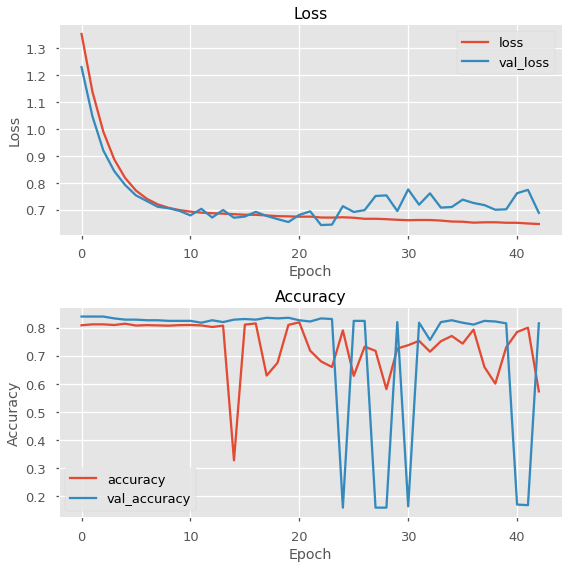

In [110]:
#GRU
plot_history(history)

# LSTM Model
#### This model will be the same except have an LSTM layer instead of GRU

In [111]:
model = Sequential()
model.add(Embedding(num_words, vec_size, input_length=max_length,
                    weights = [word_vector_matrix], trainable = False))
model.add(LSTM(64, kernel_regularizer=regularizers.l2()))
model.add(Dropout(.2))
model.add(layers.Dense(128, activation='tanh'))
model.add(Dense(1, activation="sigmoid"))
optimizer = Adam(learning_rate=3e-4)



model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])


In [112]:
history = model.fit(
    train_padded, y_train, epochs=200, validation_data=(test_padded, y_test),
    callbacks=[EarlyStopping(patience=20, restore_best_weights=True)],
    class_weight=weights
)

Epoch 1/200
67/67 [==============================] - 4s 30ms/step - loss: 1.3398 - accuracy: 0.1699 - val_loss: 1.4112 - val_accuracy: 0.1560
Epoch 2/200
67/67 [==============================] - 1s 22ms/step - loss: 1.0732 - accuracy: 0.1699 - val_loss: 1.2629 - val_accuracy: 0.1560
Epoch 3/200
67/67 [==============================] - 1s 22ms/step - loss: 0.9098 - accuracy: 0.1699 - val_loss: 1.1557 - val_accuracy: 0.1560
Epoch 4/200
67/67 [==============================] - 1s 22ms/step - loss: 0.8088 - accuracy: 0.1699 - val_loss: 1.0628 - val_accuracy: 0.1560
Epoch 5/200
67/67 [==============================] - 1s 22ms/step - loss: 0.7398 - accuracy: 0.1699 - val_loss: 1.0424 - val_accuracy: 0.1560
Epoch 6/200
67/67 [==============================] - 1s 22ms/step - loss: 0.6968 - accuracy: 0.1699 - val_loss: 0.9994 - val_accuracy: 0.1560
Epoch 7/200
67/67 [==============================] - 1s 22ms/step - loss: 0.6698 - accuracy: 0.1699 - val_loss: 0.9966 - val_accuracy: 0.1560
Epoch 

In [113]:
y_pred_probs = model.predict(val_padded)
y_pred = []
for y in y_pred_probs:
  if y > .5:
    y_pred.append(1)
  else:
    y_pred.append(0)

r_lstm = classification_report(y_val, y_pred, output_dict=False)
r_plot_lstm = classification_report(y_val, y_pred, output_dict=True)

In [114]:
print(r_lstm)

              precision    recall  f1-score   support

           0       1.00      0.02      0.04       375
           1       0.18      1.00      0.30        80

    accuracy                           0.19       455
   macro avg       0.59      0.51      0.17       455
weighted avg       0.86      0.19      0.08       455



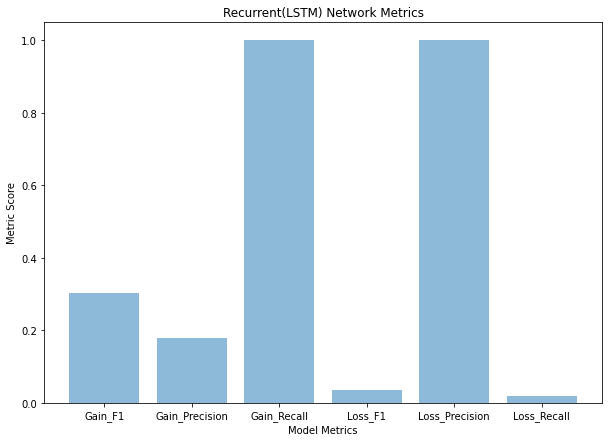

In [115]:
plot_classification_report(r_plot_lstm, 'Recurrent(LSTM) Network Metrics', labels=int)

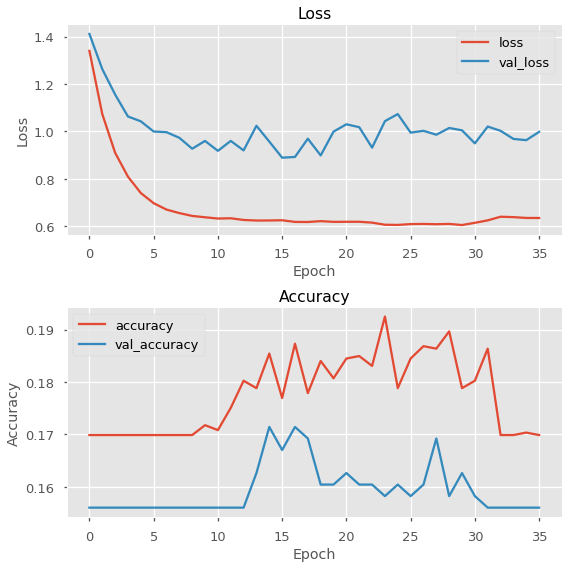

In [116]:
#LSTM 
plot_history(history)

##### Before moving on I will compare the results of the two neural networks above to an LSTM network except this time I will use a larger Glove library.

In [117]:
glove_vecs = {}
file = open('/content/drive/MyDrive/glove/glove.6B.200d.txt',
            encoding='utf-8')
for line in file:
  values = line.split()
  word = values[0]
  vectors = np.asarray(values[1:])
  glove_vecs[word] = vectors
file.close()

word_vector_matrix = np.zeros((num_words, 200))
for word, idx in tokenizer.word_index.items():
  vector = glove_vecs.get(word)
  if vector is not None:
    word_vector_matrix[idx] = vector

vec_size = 200


In [118]:
model = Sequential()
model.add(Embedding(num_words, vec_size, input_length=max_length,
                    weights = [word_vector_matrix], trainable = False))
model.add(GRU(64, kernel_regularizer=regularizers.l2()))

model.add(layers.Dense(128, activation='tanh'))
model.add(Dense(1, activation="sigmoid"))
optimizer = Adam(learning_rate=3e-4)



model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])



In [119]:
history = model.fit(
    train_padded, y_train, epochs=200, validation_data=(test_padded, y_test),
    callbacks=[EarlyStopping(patience=20, restore_best_weights=True)],
    class_weight=weights
)

Epoch 1/200
67/67 [==============================] - 4s 30ms/step - loss: 2.2384 - accuracy: 0.2113 - val_loss: 2.0777 - val_accuracy: 0.1560
Epoch 2/200
67/67 [==============================] - 1s 22ms/step - loss: 1.5930 - accuracy: 0.1699 - val_loss: 1.6654 - val_accuracy: 0.1560
Epoch 3/200
67/67 [==============================] - 1s 22ms/step - loss: 1.2009 - accuracy: 0.1699 - val_loss: 1.4069 - val_accuracy: 0.1560
Epoch 4/200
67/67 [==============================] - 1s 22ms/step - loss: 0.9613 - accuracy: 0.1699 - val_loss: 1.2121 - val_accuracy: 0.1560
Epoch 5/200
67/67 [==============================] - 1s 22ms/step - loss: 0.8170 - accuracy: 0.1699 - val_loss: 1.1008 - val_accuracy: 0.1560
Epoch 6/200
67/67 [==============================] - 1s 22ms/step - loss: 0.7340 - accuracy: 0.1699 - val_loss: 1.0304 - val_accuracy: 0.1560
Epoch 7/200
67/67 [==============================] - 1s 22ms/step - loss: 0.6859 - accuracy: 0.1699 - val_loss: 1.0120 - val_accuracy: 0.1560
Epoch 

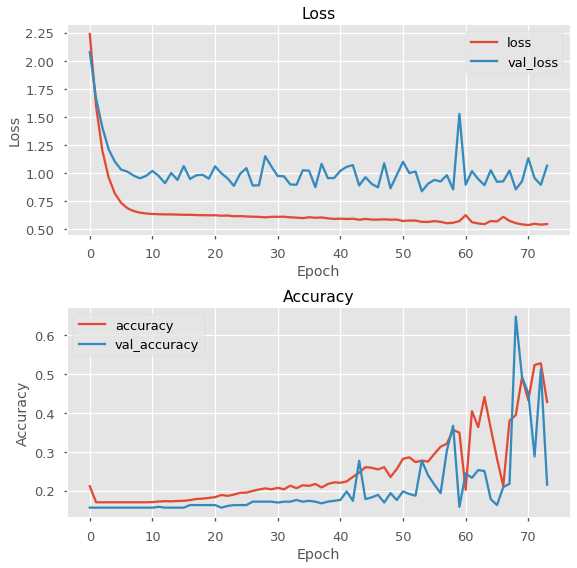

In [127]:
plot_history(history)

# Recurrent Model Evaluation
#### Similar to before, I will first streamline the process above so that I can evaluate the model on random stocks. It is important to do this because there is a possibility that this particular stock is trending upwards or downwards currently.

In [120]:
def build_recurrent_model(apikey, ticker, limit=10000):
  """
  IN: 
    apikey : FMP cloud apikey
    ticker : Stock symbol
    limit : How far back you want to collect news. Note: The higher the limit 
    the farther back in time you collect news from
  """
  print(ticker)
  #Builds data frames
  stock_df, vader_df = build_vader_model(apikey, ticker, limit=limit)
  stock_df['Date'] = stock_df.date
  #Gets y_true from stock_df
  data = add_y_true(stock_df)
  #Adds y_true to vader_df
  vader_df['y_true'] = vader_df.Stock_Prediction_Day.map(data)
  vader_df.dropna(inplace=True)
  vader_df['y_true'] = vader_df.y_true.apply(lambda val:
                          'gain'if 'g'in str(val)[5:7]
                          else('loss'))

  vader_df.reset_index(drop=True, inplace=True)
  #Combines title and text within vader_df
  vader_df = combine_text_title(vader_df)
  #NLP
  text_ = vader_df.final_text
  counter = counter_word(text_)
  num_words = len(counter)
  max_length = 50 
  #Build recurrent_df with text and y_true
  recurrent_df = vader_df[['final_text', 'y_true']]
  #Random Seed
  seed = 24

  gain_count = recurrent_df.y_true.value_counts()['gain']
  loss_count = recurrent_df.y_true.value_counts()['loss']


  
  #Train Test Split
  X = recurrent_df['final_text']
  test_size = int(np.round(X.shape[0] * .15))
  y = recurrent_df['y_true']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, 
                                                      random_state=seed)
  X_train, X_val, y_train, y_val = train_test_split(
      X_train, y_train, test_size=test_size, random_state=seed)

  #Binary Encoding
  y_test = y_test.apply(lambda el: 1 if el == 'gain' else(0))
  y_train = y_train.apply(lambda el: 1 if el == 'gain' else(0))
  y_val = y_val.apply(lambda el: 1 if el == 'gain' else(0))




  #Additional NLP
  tokenizer = Tokenizer(num_words=num_words,filters=('–', '/'))
  tokenizer.fit_on_texts(X_train) 
  word_index = tokenizer.word_index
  train_sequences = tokenizer.texts_to_sequences(X_train)
  train_padded = pad_sequences(
    train_sequences, maxlen=max_length, padding="post", truncating="post"
)
  test_sequences = tokenizer.texts_to_sequences(X_test)
  test_padded = pad_sequences(
    test_sequences, maxlen=max_length, padding="post", truncating="post"
)
  val_sequences = tokenizer.texts_to_sequences(X_val)
  val_padded = pad_sequences(
    val_sequences, maxlen=max_length, padding="post", truncating="post"
)
  #Create Model
  model = create_reccurent_model(max_length, num_words, weights)
  #Compile Model
  compile_recurrent_model(model)
  #Fit model
  train_recurrent_model(model, train_padded, y_train, test_padded, y_test)
  return (model, y_val, val_padded)



In [131]:
def create_reccurent_model(max_length, num_words, weights, LSTM_=False, 
                           GRU_=True, dropout=False, dropout_rate=.15,
                           extra_layer=False, extra_layer_activation = 'tanh',
                           starting_nodes = 50):
  """
  IN:
    max_length : Max length of text per text space. Standard is 50
    num_words : The amound of unique words to be processed
    weights: Dictionary with y_true.unique() as keys and associated weight as value
    LSTM : Bool, if you want LSTM instead of GRU
    GRU : Bool, if you want GRU
    Dropout: Bool, if you want to add a dropout layer
    dropout_rate : Percentage of neurons to be dropped if there is a dropout
    extra_layer : Bool, if you want to add another dense layer
    extra_layer_activation: activation function for extra layer
    starting_nodes: Number of neurons in the first layer. Note: Every layer
    after the input layer will have twice as many neurons as the layer before it
  OUT:
    Model: Uncompiled Neural Network

  """
  vec_size = 50
  model = Sequential()
  n = starting_nodes
  glove_vecs = {}
  file = open('/content/drive/MyDrive/glove/glove.6B.50d.txt',
              encoding='utf-8')
  for line in file:
    values = line.split()
    word = values[0]
    vectors = np.asarray(values[1:])
    glove_vecs[word] = vectors
  file.close()

  this_word_vector_matrix = np.zeros((num_words, 50))
  for word, idx in tokenizer.word_index.items():
    vector = glove_vecs.get(word)
    if vector is not None:
      this_word_vector_matrix[idx] = vector

  model.add(Embedding(num_words, vec_size, input_length=max_length,
                    weights = [this_word_vector_matrix], trainable = False))
  n = n*2

  if extra_layer == True:
    model.add(layers.Dense(n, activation=extra_layer_activation))
    n = n*2
  if dropout == True:
    model.add(Dropout(.2))
  if LSTM_ == True:
    model.add(LSTM(n))
    n = n*2
  elif GRU_ == True:
    model.add(GRU(n))
    n = n*2

  model.add(Dense(1, activation="sigmoid"))


  optimizer = Adam(learning_rate=3e-4)
  return model
  
def compile_recurrent_model(model, loss='squared_hinge',optimizer='adam',
                            metrics=['accuracy']):
  """
  IN:
    model : Neural network to be compiled
    loss: Loss function of model
    optimzer : Optimizer function of model
    metrics : list, metrics to be measured during training
  """
  model.compile(loss=loss, optimizer=optimizer, metrics=metrics)




In [122]:
def analyze_recurrent_model(model, x_val, y_val, output=True):
  """
  IN:  
    model : Artificial Neural Network already compiled
    x_val : Unseen validation set for prediction
    y_val : Correct values for x_val set
    output: Bool, if want to print the classification report set False
  OUT:  
    classification_report : Based on prediction made by model on x_val set
    compared against y_val set
  """

  y_pred_probs = model.predict(x_val)
  y_pred = []
  for y in y_pred_probs:
    if y > .5:
      y_pred.append(1)
    else:
      y_pred.append(0)
  
  return(classification_report(y_val, y_pred, labels=[1,0], 
                               output_dict=output))

In [123]:
def train_recurrent_model(model, x_train, y_train, x_test, y_test,
                          patience=25, epochs=200):
  
  class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train), y_train)                                              
  weights_sk = {
      0: class_weights[0],
      1: class_weights[1]
  }
  l = y_train.value_counts()[0]
  g = y_train.value_counts()[1]
                                                
  weights = {
      0: ((g/l)+weights_sk[0])/2,
      1: ((l/g)+weights_sk[1])/2
  }
  

  model.fit(x_train, y_train, epochs=epochs, class_weight=weights,
          callbacks=[EarlyStopping(patience=20, restore_best_weights=True)],
          validation_data=(x_test, y_test)
          )
  

In [132]:
limit = 80_000

symbols = get_random_symbols(apikey, 10)


model, y_val, x_val = build_recurrent_model(apikey, symbols, limit=limit)

#Builds classification report
r_gru = analyze_recurrent_model(model, x_val, y_val, output=False)
r_gru_plot = analyze_recurrent_model(model, x_val, y_val, output=True)




['IVZ', 'MKTX', 'PXD', 'XRAY', 'GS', 'SYY', 'WMB', 'RMD', 'EFX', 'GE']
Epoch 1/200
127/127 [==============================] - 4s 18ms/step - loss: 0.8249 - accuracy: 0.8088 - val_loss: 1.8937 - val_accuracy: 0.9194
Epoch 2/200
127/127 [==============================] - 2s 16ms/step - loss: 0.8153 - accuracy: 0.8458 - val_loss: 1.8849 - val_accuracy: 0.8906
Epoch 3/200
127/127 [==============================] - 2s 15ms/step - loss: 0.8069 - accuracy: 0.8631 - val_loss: 1.9286 - val_accuracy: 0.8687
Epoch 4/200
127/127 [==============================] - 2s 15ms/step - loss: 0.7911 - accuracy: 0.8577 - val_loss: 1.7091 - val_accuracy: 0.8952
Epoch 5/200
127/127 [==============================] - 2s 15ms/step - loss: 0.7794 - accuracy: 0.8772 - val_loss: 1.8886 - val_accuracy: 0.8871
Epoch 6/200
127/127 [==============================] - 2s 15ms/step - loss: 0.7671 - accuracy: 0.8844 - val_loss: 1.8680 - val_accuracy: 0.8502
Epoch 7/200
127/127 [==============================] - 2s 15ms/st

              precision    recall  f1-score   support

           1       0.16      0.07      0.09        76
           0       0.92      0.97      0.94       792

    accuracy                           0.89       868
   macro avg       0.54      0.52      0.52       868
weighted avg       0.85      0.89      0.87       868



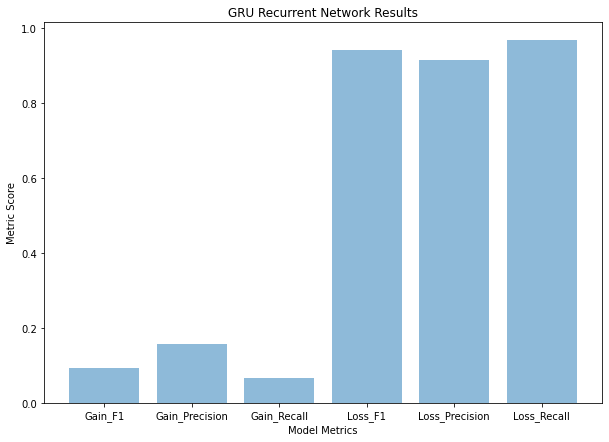

In [135]:
print(r_gru)
plot_classification_report(r_gru_plot, 'GRU Recurrent Network Results',
                           labels=int)

# Recurrent Network Evaluation

#### The recurrent network performed much better than the baseline model in general. This is based on the y_axis scale of this analyis chart compared to the baseline chart. Consistently, I am seeing the class imbalance strongly influence the results of the model. I will further investigate the proper weights, somtimes the sklearn weights are sufficient but other times I use the more general formula of class_weigth = class/other_class. The model currently gets the average between these two weight forumulas but I will determine the best weights depending on the ratio.

#### In conclusion this model is much stronger, for our data it appears that the GRU neural network performs better. I will now make a vanilla transformer model using the distil BERT which is a ligher version of the BERT model but retains 95% of it's stren



# Transformer Model

In [17]:
%reload_ext autoreload
%autoreload 2
os.environ["CUBA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUBA_VISIBLE_DEVICES"]="0"

## Data Preparation
#### This will be the same as the recurrent model

# Model Construction

In [21]:
syms = get_random_symbols(apikey)
stock_df, vader_df = build_vader_model(apikey, syms, limit=10_000)
stock_df['Date'] = stock_df.date
#Gets y_true from stock_df
data = add_y_true(stock_df)
#Adds y_true to vader_df
vader_df['y_true'] = vader_df.Stock_Prediction_Day.map(data)
vader_df.dropna(inplace=True)
vader_df['y_true'] = vader_df.y_true.apply(lambda val:
                        'gain'if 'g'in str(val)[5:7]
                        else('loss'))

vader_df.reset_index(drop=True, inplace=True)
#Combines title and text within vader_df
vader_df = combine_text_title(vader_df)
#NLP
text_ = vader_df.final_text
counter = counter_word(text_)
num_words = len(counter)
max_length = 90 
#Build recurrent_df with text and y_true
transformer_df = vader_df[['final_text', 'y_true']]
#Random Seed
seed = 24


#Train Test Split
X = transformer_df['final_text']
y = transformer_df['y_true']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, 
                                                    random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=.3, random_state=seed)
#Binary Encoding
y_test = y_test.apply(lambda el: 1 if el == 'gain' else(0))
y_train = y_train.apply(lambda el: 1 if el == 'gain' else(0))
y_val = y_val.apply(lambda el: 1 if el == 'gain' else(0))




In [24]:
model_name = 'distilbert-base-uncased'
trans = text.Transformer(model_name, maxlen=412,class_names=['gain','loss']
                         )

In [25]:
train_data = trans.preprocess_train(list(X_train), list(y_train))
test_data =trans.preprocess_test(list(X_test), list(y_test))

preprocessing train...
language: en
train sequence lengths:
	mean : 50
	95percentile : 96
	99percentile : 392


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 48
	95percentile : 94
	99percentile : 236


In [26]:
model = trans.get_classifier()

DEBUG:filelock:Attempting to acquire lock 139659211302416 on /root/.cache/huggingface/transformers/fa107dc22c014df078a1b75235144a927f7e9764916222711f239b7ee6092ec9.bc4b731be56d8422e12b1d5bfa86fbd81d18d2770da1f5ac4f33640a17b7dde9.h5.lock
DEBUG:filelock:Lock 139659211302416 acquired on /root/.cache/huggingface/transformers/fa107dc22c014df078a1b75235144a927f7e9764916222711f239b7ee6092ec9.bc4b731be56d8422e12b1d5bfa86fbd81d18d2770da1f5ac4f33640a17b7dde9.h5.lock


Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 139659211302416 on /root/.cache/huggingface/transformers/fa107dc22c014df078a1b75235144a927f7e9764916222711f239b7ee6092ec9.bc4b731be56d8422e12b1d5bfa86fbd81d18d2770da1f5ac4f33640a17b7dde9.h5.lock
DEBUG:filelock:Lock 139659211302416 released on /root/.cache/huggingface/transformers/fa107dc22c014df078a1b75235144a927f7e9764916222711f239b7ee6092ec9.bc4b731be56d8422e12b1d5bfa86fbd81d18d2770da1f5ac4f33640a17b7dde9.h5.lock


In [27]:
learner = ktrain.get_learner(model, train_data = train_data, 
                              val_data=test_data,
                              batch_size=16)



In [ ]:
learner.lr_find(show_plot=True, max_epochs=10)

In [28]:
learner.fit_onecycle(1e-4, 1)



begin training using onecycle policy with max lr of 0.0001...
158/158 [==============================] - 264s 2s/step - loss: 0.3368 - accuracy: 0.9006 - val_loss: 0.2607 - val_accuracy: 0.9268


In [134]:
learner.validate()

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1115
           1       0.00      0.00      0.00        88

    accuracy                           0.93      1203
   macro avg       0.46      0.50      0.48      1203
weighted avg       0.86      0.93      0.89      1203



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1115,    0],
       [  88,    0]])

# Results

## Text Sentiment
The vader sentiment model that uses machine learning consistenly labeled the text score as the most valuable. I will now validate that assumption by making many xgboost models some of which will not have include sentiment scores for text. The steps I will take are:
 - Make 10 models
 - Keep count of the top 3 most important features
 - Plot count with labels
 - Make 10 models without text scores
 - Make 10 models without title scores
 - Compare & visualize results



In [ ]:
#Average Feature Importances
#After each loop I will add the importance dataframe to the importance_df_list
#This list will be used to look at average best featrues
importance_df_list = []
#After each loop I will add the plottable report to this list to compare
#later. These metrics will include text & title scores where the next set
#of models will contain only text and only title scores
model_metric_text_title = []
for i in range(10):
  randoms = get_random_symbols(apikey, 10)
  stock_df, vader_df = build_vader_model(apikey, randoms, limit=5000)
  data = add_y_true(stock_df)
  vader_df['y_true'] = vader_df.Stock_Prediction_Day.map(data)
  vader_df.dropna(inplace=True)
  vader_df['y_true'] = vader_df.y_true.apply(lambda val:
                          'gain'if 'g'in str(val)[5:7]
                          else('loss'))

  vader_df.reset_index(drop=True, inplace=True)

  X = vader_df[['NegativeScoreText', 'CompoundAvg', 'CompoundScoreTitle', 'PositiveScoreTitle',
                'NegativeScoreTitle', 'CompoundScoreText', 'NeutralScoreTitle', 'NeutralScoreText',
                'PositiveScoreText']]
  y = vader_df['y_true']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=24)

  sc = StandardScaler()
  X_train_scaled = pd.DataFrame(sc.fit_transform(X_train), columns=X_train.columns)
  X_test_scaled = pd.DataFrame(sc.transform(X_test), columns = X_test.columns)

  l = y_train.value_counts()['loss']
  g = y_train.value_counts()['gain']

  weight = l / g
  weight

  y_test = y_test.apply(lambda el: 1 if el == 'gain' else(0))
  y_train = y_train.apply(lambda el: 1 if el == 'gain' else(0))

  results_xg = XGBClassifier(scale_pos_weight=(weight))
  results_xg.fit(X_train_scaled, y_train)

  results_report = classification_report(y_test, results_xg.predict(X_test_scaled), 
                                  output_dict=True)

  importance_df = pd.DataFrame(results_xg.feature_importances_, columns=['importance'])
  importance_df['feature_name'] = X_train_scaled.columns

  importance_df.sort_values('importance', ascending=False, inplace=True)
  importance_df.reset_index(drop=True, inplace=True)
  importance_df_list.append(importance_df)
  
  model_metric_text_title.append(results_report)



In [ ]:
first = []
second = []
third = []
#Here I am looping through the importance dataframes.
#I am using a custom scoring system that I will use to visualize the results

for df in importance_df_list:
  one = df.feature_name[0]
  two = df.feature_name[1]
  three = df.feature_name[2]
  first.append(one)
  second.append(two)
  third.append(three)

In [ ]:
counter = {}
for f in first:
  if f in counter.keys():
    counter[f] += 1
  else:
    counter[f] = 1

<BarContainer object of 5 artists>

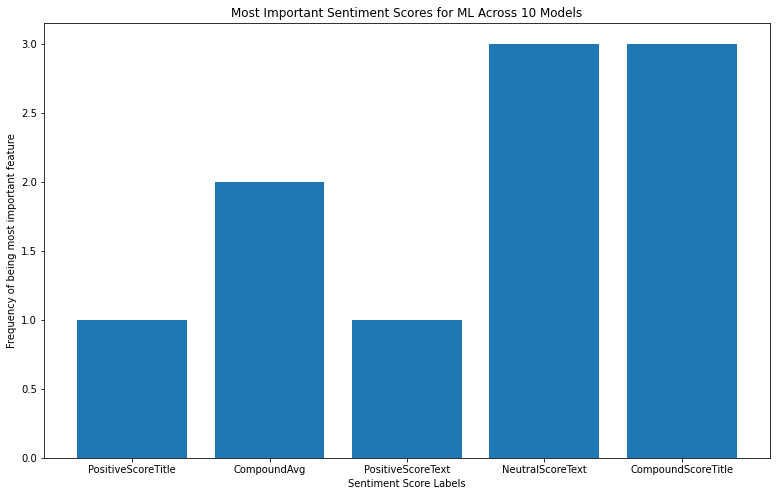

In [ ]:
x_cats = counter.keys()
y = counter.values()
plt.figure(figsize=(13,8))
plt.title('Most Important Sentiment Scores for ML Across 10 Models')
plt.xlabel('Sentiment Score Labels')
plt.ylabel('Frequency of being most important feature')
plt.bar(x_cats, y)

### Now, I will make 20 more models, 10 will not have text sentiment scores, 10 will not have title sentiment scores.

In [ ]:

#After each loop I will add the plottable report to this list to compare
#later. 1/2 of the models will include text and 1/2 will contail title
model_metric_text = []
model_metric_title = []
for i in range(20):
  randoms = get_random_symbols(apikey, 10)
  stock_df, vader_df = build_vader_model(apikey, randoms, limit=5000)
  data = add_y_true(stock_df)
  vader_df['y_true'] = vader_df.Stock_Prediction_Day.map(data)
  vader_df.dropna(inplace=True)
  vader_df['y_true'] = vader_df.y_true.apply(lambda val:
                          'gain'if 'g'in str(val)[5:7]
                          else('loss'))

  vader_df.reset_index(drop=True, inplace=True)

  X = vader_df[['NegativeScoreText', 'CompoundAvg', 'CompoundScoreTitle', 'PositiveScoreTitle',
                'NegativeScoreTitle', 'CompoundScoreText', 'NeutralScoreTitle', 'NeutralScoreText',
                'PositiveScoreText']]
  y = vader_df['y_true']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=24)

  sc = StandardScaler()
  X_train_scaled = pd.DataFrame(sc.fit_transform(X_train), columns=X_train.columns)
  X_test_scaled = pd.DataFrame(sc.transform(X_test), columns = X_test.columns)

  l = y_train.value_counts()['loss']
  g = y_train.value_counts()['gain']

  weight = l / g
  weight

  y_test = y_test.apply(lambda el: 1 if el == 'gain' else(0))
  y_train = y_train.apply(lambda el: 1 if el == 'gain' else(0))
  if i >= 9:
    X_train_scaled.drop(columns=['NegativeScoreText', 'CompoundAvg', 'NeutralScoreText',
                                 'PositiveScoreText'], inplace=True)
    X_test_scaled.drop(columns=['NegativeScoreText', 'CompoundAvg', 'NeutralScoreText',
                                 'PositiveScoreText'], inplace=True)
  elif i <= 10:
    X_train_scaled.drop(columns=['NegativeScoreTitle', 'CompoundAvg', 'NeutralScoreTitle',
                                 'PositiveScoreTitle'], inplace=True)
    X_test_scaled.drop(columns=['NegativeScoreTitle', 'CompoundAvg', 'NeutralScoreTitle',
                                 'PositiveScoreTitle'], inplace=True)

    

  results_xg = XGBClassifier(scale_pos_weight=(weight))
  results_xg.fit(X_train_scaled, y_train)

  results_report = classification_report(y_test, results_xg.predict(X_test_scaled), 
                                  output_dict=True)

  if i >= 9:
    model_metric_title.append(results_report)
  elif i <= 10:
    model_metric_text.append(results_report)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


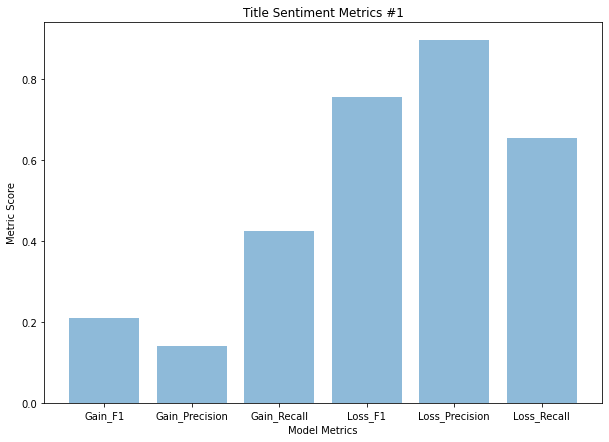

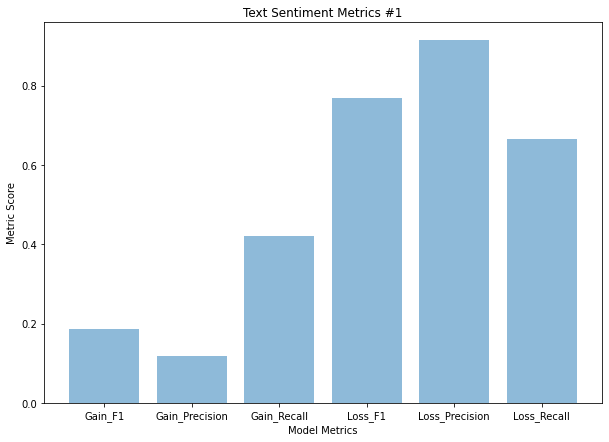

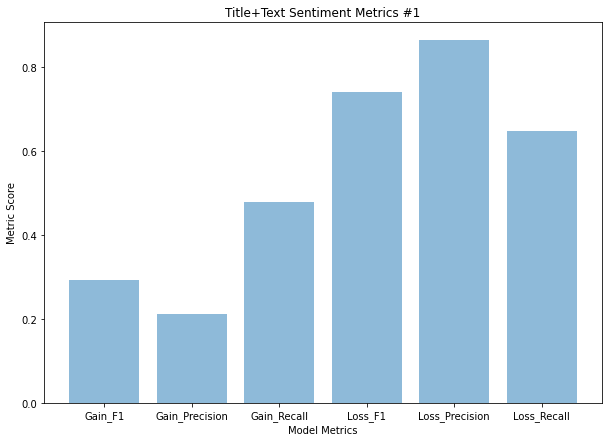

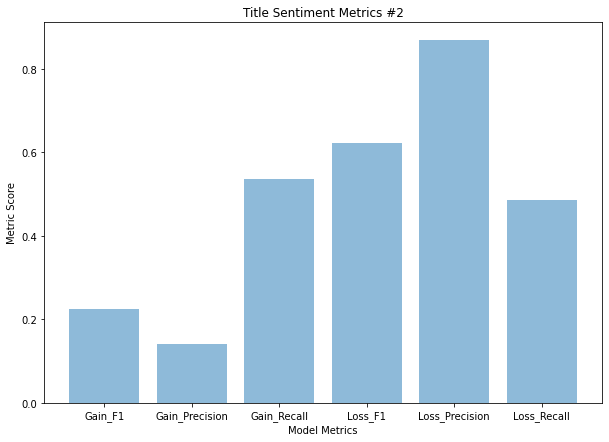

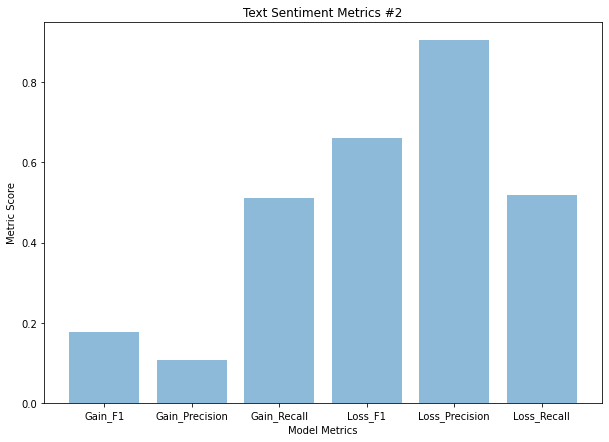

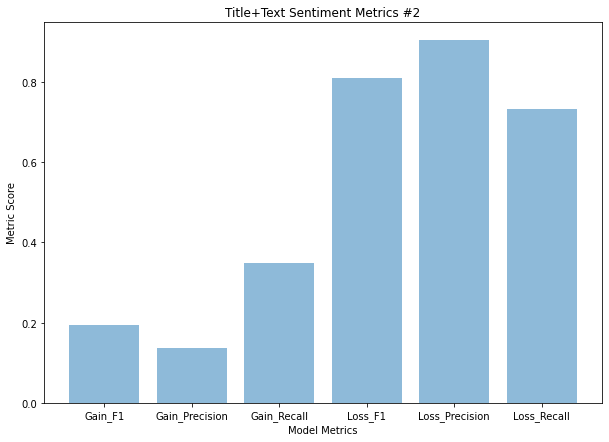

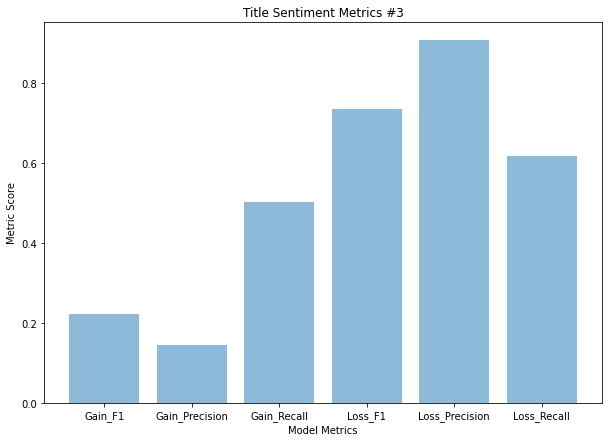

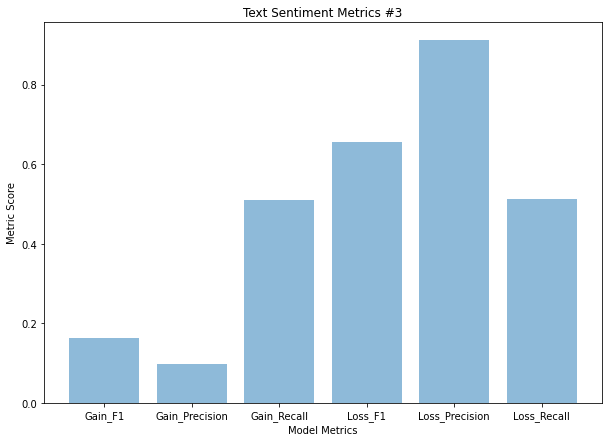

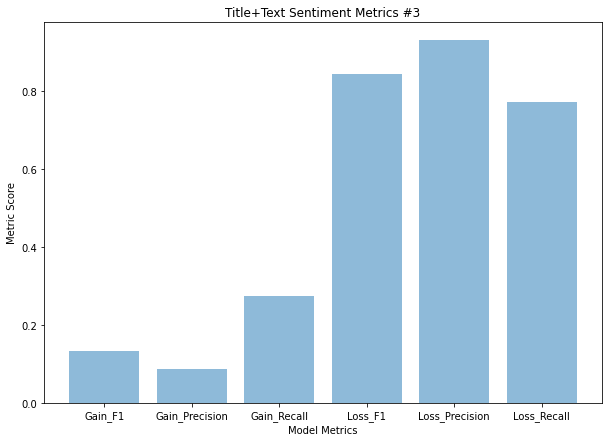

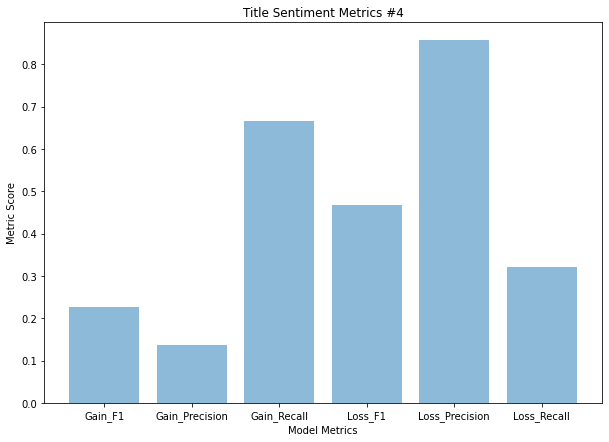

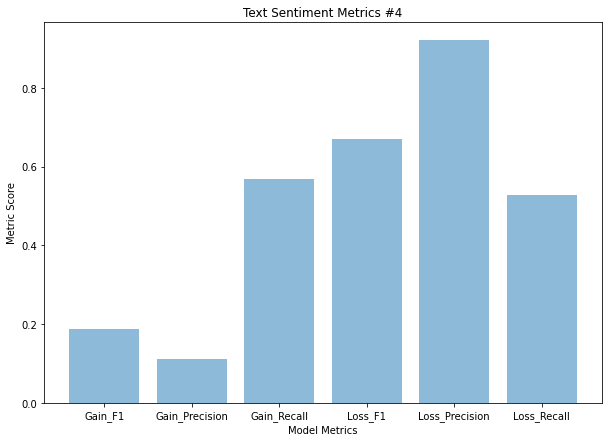

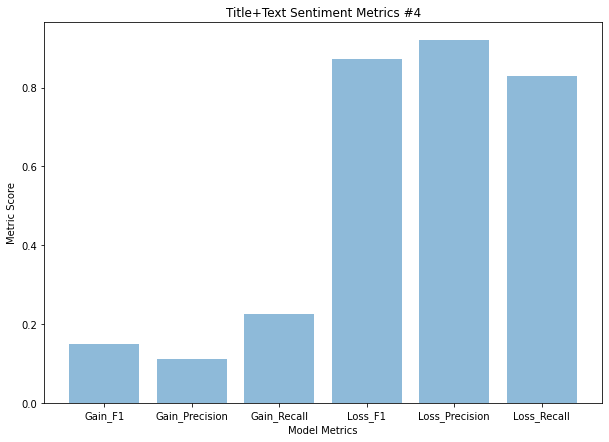

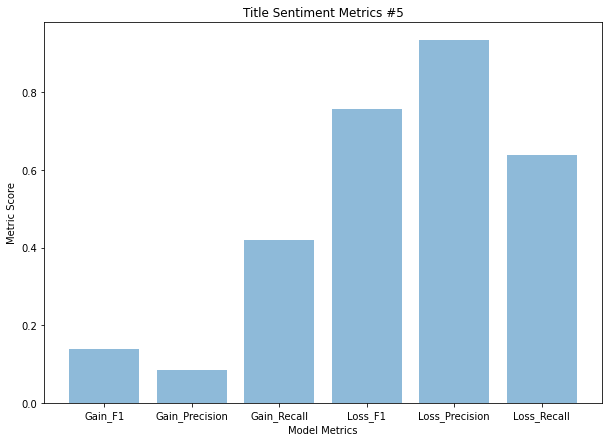

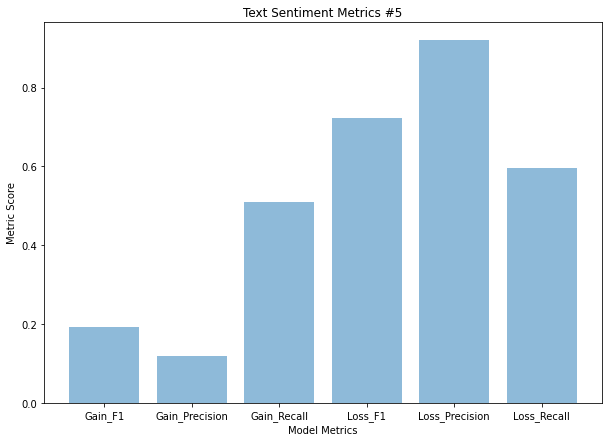

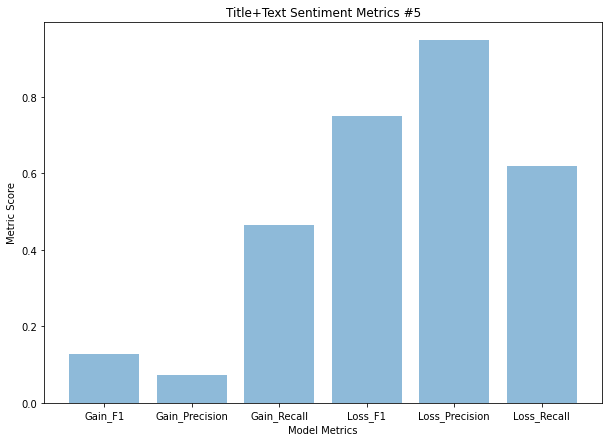

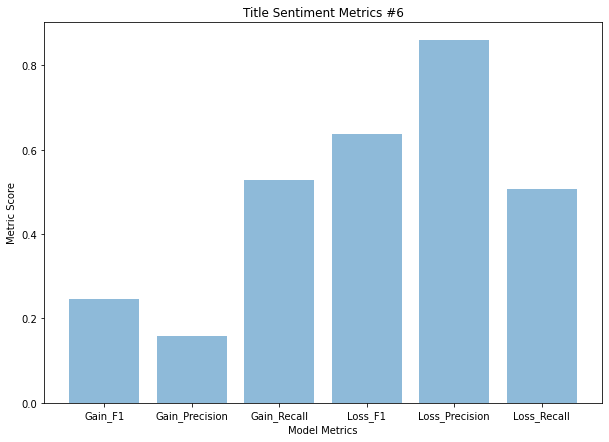

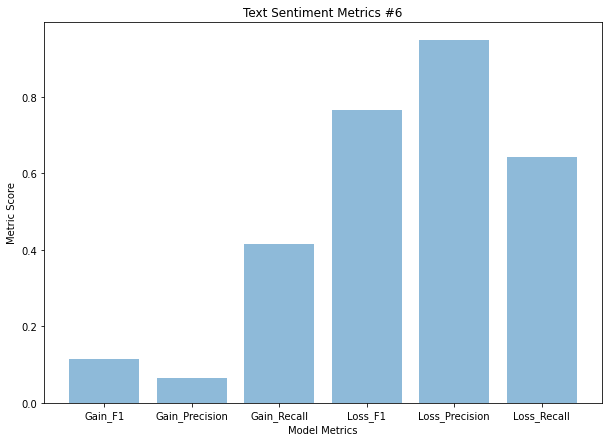

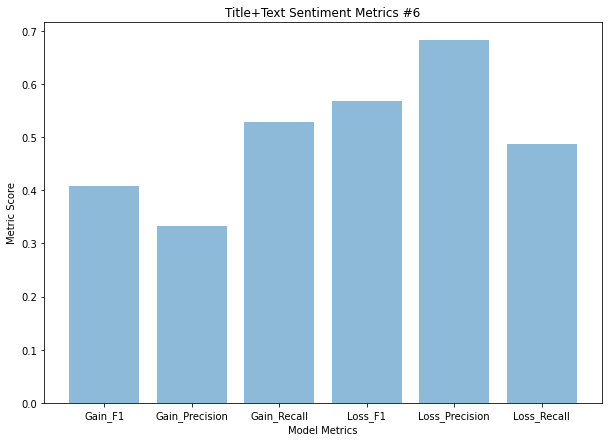

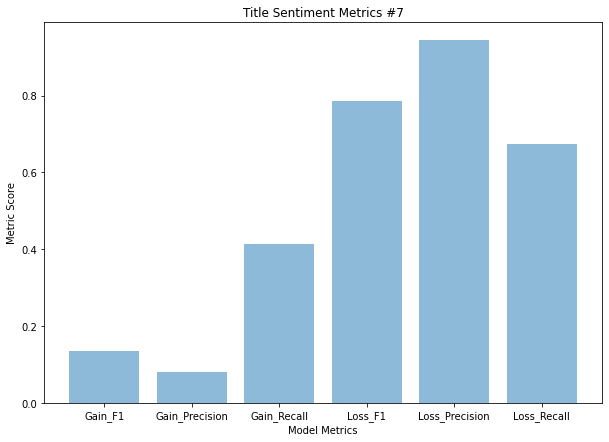

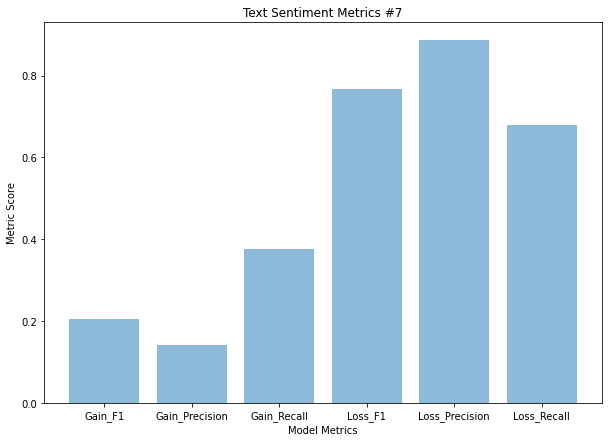

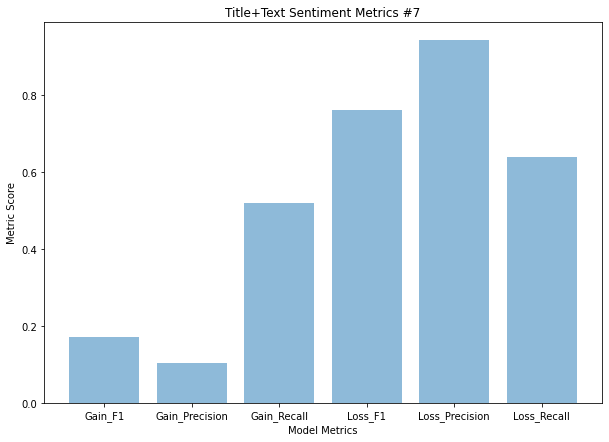

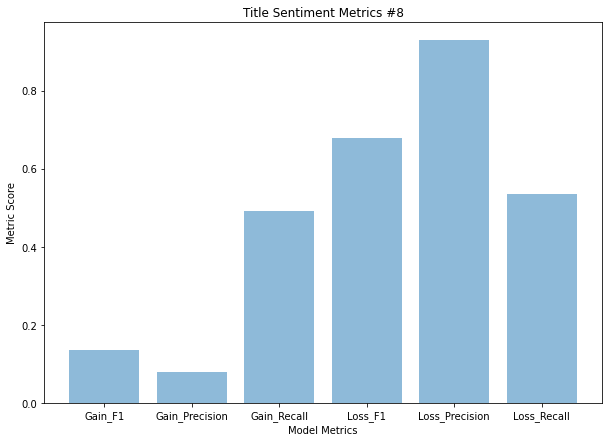

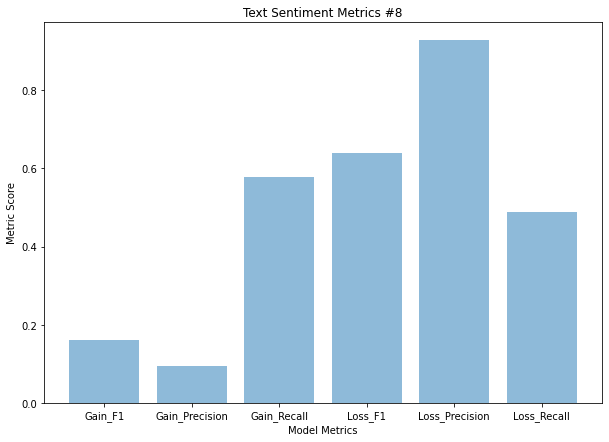

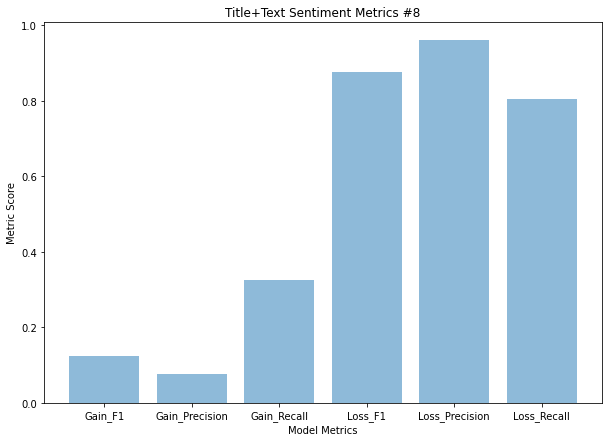

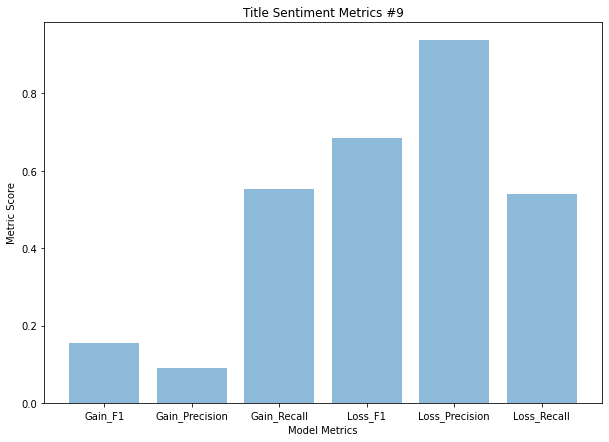

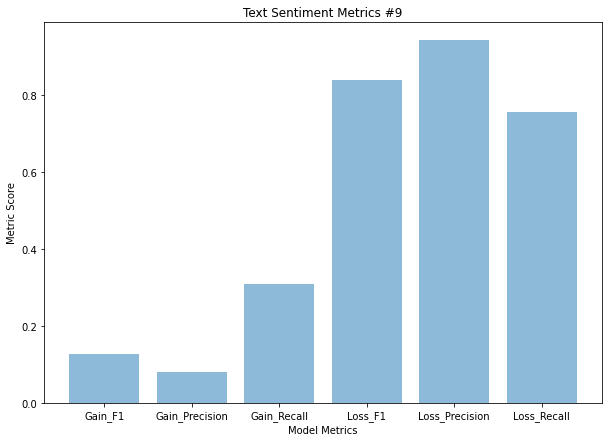

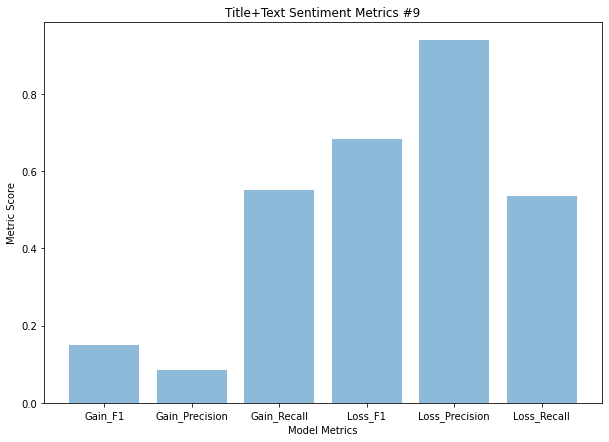

In [ ]:
import itertools 
coun = 1
for (title_r, text_r, both_r) in zip(model_metric_title, model_metric_text, 
                                     model_metric_text_title):
     
     plot_classification_report(title_r, 'Title Sentiment Metrics #'+str(coun),
                                labels=int)
     plot_classification_report(text_r, 'Text Sentiment Metrics #'+str(coun),
                                labels=int)
     plot_classification_report(both_r, 'Title+Text Sentiment Metrics #'+str(coun),
                                labels=int)
     coun+=1




## Best Weights to Use for Neural Network
#### For this investigation I will once again loop 10 times through the prepocessing steps for the neural network. Each loop I will save the word_vec_list, y_train_list, x_trains, y_tests, x_tests, y_validations, and x_validations. The purpose of this is to derive the best weights to ratios of class imbalance.

In [ ]:
 word_vec_list = []
 y_train_list = []
 train_padded_list = [] 
 y_test_list = []
 test_padded_list = []
 y_val_list = []
 val_padded_list = []
 num_word_list = []
for i in range(10):  
  random = get_random_symbols(apikey, 15)
  stock_df, df = build_vader_model(apikey, random, limit=9500)
  stock_df['Date'] = stock_df.date
  data = add_y_true(stock_df)
  vader_df['y_true'] = vader_df.Stock_Prediction_Day.map(data)
  vader_df.dropna(inplace=True)
  vader_df['y_true'] = vader_df.y_true.apply(lambda val:
                          'gain'if 'g'in str(val)[5:7]
                          else('loss'))

  vader_df.reset_index(drop=True, inplace=True)
  vader_df = combine_text_title(vader_df).copy()
  text_ = vader_df.final_text
  counter = counter_word(text_)
  num_words = len(counter)
  max_length = 90

  recurrent_df = vader_df[['final_text', 'y_true']].copy()

  seed = 24

  X = recurrent_df['final_text']
  test_size = int(np.round(X.shape[0] * .15))
  y = recurrent_df['y_true']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, 
                                                      random_state=seed)
  X_train, X_val, y_train, y_val = train_test_split(
      X_train, y_train, test_size=test_size, random_state=seed)

  y_test = y_test.apply(lambda el: 1 if el == 'gain' else(0))
  y_train = y_train.apply(lambda el: 1 if el == 'gain' else(0))
  y_val = y_val.apply(lambda el: 1 if el == 'gain' else(0))

  #TOKENIZE
  #Removes Puncuation
  tokenizer = Tokenizer(num_words=num_words, filters=('–', '/'))
  tokenizer.fit_on_texts(X_train)
  word_index = tokenizer.word_index
  #Sequencing
  train_sequences = tokenizer.texts_to_sequences(X_train)
  train_padded = pad_sequences(
      train_sequences, maxlen=max_length, padding="post", truncating="post"
  )
  test_sequences = tokenizer.texts_to_sequences(X_test)
  test_padded = pad_sequences(
      test_sequences, maxlen=max_length, padding="post", truncating="post"
  )
  val_sequences = tokenizer.texts_to_sequences(X_val)
  val_padded = pad_sequences(
      val_sequences, maxlen=max_length, padding="post", truncating="post"
  )

  glove_vecs = {}
  file = open('/content/gdrive/MyDrive/glove/glove.6B.50d.txt',
              encoding='utf-8')
  for line in file:
    values = line.split()
    word = values[0]
    vectors = np.asarray(values[1:])
    glove_vecs[word] = vectors
  file.close()

  word_vector_matrix = np.zeros((num_words, 50))
  for word, idx in tokenizer.word_index.items():
    vector = glove_vecs.get(word)
    if vector is not None:
      word_vector_matrix[idx] = vector

  vec_size = 50

  word_vec_list.append(word_vector_matrix)
  num_word_list.append(num_words)


  y_train_list.append(y_train)
  train_padded_list.append(train_padded)

  y_test_list.append(y_test)
  test_padded_list.append(test_padded)

  y_val_list.append(y_val)
  val_padded_list.append(val_padded)


In [ ]:
(len(word_vec_list), len(y_train_list), len(y_test_list), len(train_padded_list),
 len(test_padded_list), len(y_val_list), len(val_padded_list), len(num_word_list))

(10, 10, 10, 10, 10, 10, 10, 10)

In [ ]:
i = 1
ratio_list = []
for y in y_train_list:
  print('Classes Example #'+str(i))
  print(y.value_counts())
  l = y.value_counts()[0]
  g = y.value_counts()[1]
  ratio_list.append(l/g)
  i+=1

Classes Example #1
0    1707
1     292
Name: y_true, dtype: int64
Classes Example #2
0    1703
1     296
Name: y_true, dtype: int64
Classes Example #3
0    1757
1     242
Name: y_true, dtype: int64
Classes Example #4
0    1713
1     249
Name: y_true, dtype: int64
Classes Example #5
0    1511
1     278
Name: y_true, dtype: int64
Classes Example #6
0    1524
1     265
Name: y_true, dtype: int64
Classes Example #7
0    1521
1     268
Name: y_true, dtype: int64
Classes Example #8
0    1568
1     221
Name: y_true, dtype: int64
Classes Example #9
0    1499
1     290
Name: y_true, dtype: int64
Classes Example #10
0    1517
1     272
Name: y_true, dtype: int64


In [ ]:
max_ = max(ratio_list)

In [ ]:
min_ = min(ratio_list)

In [ ]:
idx = 0
for r in ratio_list:
  if r == max_:
    print('Max at '+str(idx))
    min_idx = idx
  if r == min_:
    print('Min at '+str(idx))
    max_idx = idx
  idx += 1


Max at 2
Min at 8


#### Now, I will make three different models for the lowest ration and the highest ratio. The first model will use the sklearn weights, the second model will use the general weight formula, and the third model will average the two. The purpose of this is to see if their is a better way to determine weights for different imbalance ratios.

In [117]:
# Minimum Ratio Models
# First model will be sk learn weights
# Second model will be general weights 
# Third model will be the average of the two
min_model_metrics = []


word_vector_matrix = word_vec_list[min_idx]
num_words = num_word_list[min_idx]

y_train = y_train_list[min_idx]
train_padded = train_padded_list[min_idx]

y_test = y_test_list[min_idx]
test_padded = test_padded_list[min_idx]

y_val = y_val_list[min_idx]
val_padded = val_padded_list[min_idx]



for i in range(3):
  model = Sequential()
  model.add(Embedding(num_words, vec_size, input_length=max_length,
                      weights = [word_vector_matrix], trainable = False))
  model.add(GRU(64, kernel_regularizer=regularizers.l2()))

  model.add(layers.Dense(128, activation='tanh'))
  model.add(Dense(1, activation="sigmoid"))
  optimizer = Adam(learning_rate=3e-4)



  model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

  
  if i == 0:
    class_weights = class_weight.compute_class_weight('balanced', 
                                                    np.unique(y_train), y_train) 
    weights = {
      0: class_weights[0],
      1: class_weights[1]
  }
  elif i == 1:
    l = y_train.value_counts()[0]
    g = y_train.value_counts()[1]
    weights = {
      0: g/l,
      1: l/g
  }
  elif i == 2:
    class_weights = class_weight.compute_class_weight('balanced', 
                                                    np.unique(y_train), y_train) 
    weights = {
      0: class_weights[0],
      1: class_weights[1]
  }

  l = y_train.value_counts()[0]
  g = y_train.value_counts()[1]
                                                
  weights = {
      0: ((g/l)+weights[0])/2,
      1: ((l/g)+weights[1])/2
  }


  history = model.fit(
      train_padded, y_train, epochs=150, validation_data=(test_padded, y_test),
      callbacks=[EarlyStopping(patience=20, restore_best_weights=True)],
      class_weight=weights
  )
  y_pred_probs = model.predict(val_padded)
  y_pred = []
  for y in y_pred_probs:
    if y > .5:
      y_pred.append(1)
    else:
      y_pred.append(0)
  r_plot = classification_report(y_val, y_pred, output_dict=True)
  min_model_metrics.append(r_plot)

Epoch 1/150
63/63 [==============================] - 7s 74ms/step - loss: 1.3336 - accuracy: 0.1616 - val_loss: 1.3865 - val_accuracy: 0.1379
Epoch 2/150
63/63 [==============================] - 3s 51ms/step - loss: 1.0867 - accuracy: 0.1211 - val_loss: 1.4355 - val_accuracy: 0.1379
Epoch 3/150
63/63 [==============================] - 3s 50ms/step - loss: 0.9384 - accuracy: 0.1211 - val_loss: 1.3102 - val_accuracy: 0.1379
Epoch 4/150
63/63 [==============================] - 3s 51ms/step - loss: 0.8379 - accuracy: 0.1221 - val_loss: 1.2446 - val_accuracy: 0.1379
Epoch 5/150
63/63 [==============================] - 3s 51ms/step - loss: 0.7687 - accuracy: 0.1246 - val_loss: 1.2182 - val_accuracy: 0.1379
Epoch 6/150
63/63 [==============================] - 3s 49ms/step - loss: 0.7195 - accuracy: 0.1216 - val_loss: 1.1165 - val_accuracy: 0.1379
Epoch 7/150
63/63 [==============================] - 3s 50ms/step - loss: 0.6858 - accuracy: 0.1241 - val_loss: 1.1129 - val_accuracy: 0.1402
Epoch 

In [120]:
len(min_model_metrics)

3

In [123]:
# Maximum Ratio Models
# First model will be sk learn weights
# Second model will be general weights 
# Third model will be the average of the two
max_model_metrics = []


word_vector_matrix = word_vec_list[max_idx]
num_words = num_word_list[max_idx]

y_train = y_train_list[max_idx]
train_padded = train_padded_list[max_idx]

y_test = y_test_list[max_idx]
test_padded = test_padded_list[max_idx]

y_val = y_val_list[max_idx]
val_padded = val_padded_list[max_idx]



for i in range(3):
  model = Sequential()
  model.add(Embedding(num_words, vec_size, input_length=max_length,
                      weights = [word_vector_matrix], trainable = False))
  model.add(GRU(64, kernel_regularizer=regularizers.l2()))

  model.add(layers.Dense(128, activation='tanh'))
  model.add(Dense(1, activation="sigmoid"))
  optimizer = Adam(learning_rate=3e-4)



  model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

  
  if i == 0:
    class_weights = class_weight.compute_class_weight('balanced', 
                                                    np.unique(y_train), y_train) 
    weights = {
      0: class_weights[0],
      1: class_weights[1]
  }
  elif i == 1:
    l = y_train.value_counts()[0]
    g = y_train.value_counts()[1]
    weights = {
      0: g/l,
      1: l/g
  }
  elif i == 2:
    class_weights = class_weight.compute_class_weight('balanced', 
                                                    np.unique(y_train), y_train) 
    weights = {
      0: class_weights[0],
      1: class_weights[1]
  }

  l = y_train.value_counts()[0]
  g = y_train.value_counts()[1]
                                                
  weights = {
      0: ((g/l)+weights[0])/2,
      1: ((l/g)+weights[1])/2
  }


  history = model.fit(
      train_padded, y_train, epochs=150, validation_data=(test_padded, y_test),
      callbacks=[EarlyStopping(patience=20, restore_best_weights=True)],
      class_weight=weights
  )
  y_pred_probs = model.predict(val_padded)
  y_pred = []
  for y in y_pred_probs:
    if y > .5:
      y_pred.append(1)
    else:
      y_pred.append(0)
  r_plot = classification_report(y_val, y_pred, output_dict=True)
  max_model_metrics.append(r_plot)

Epoch 1/150
56/56 [==============================] - 5s 59ms/step - loss: 1.3518 - accuracy: 0.1677 - val_loss: 1.4036 - val_accuracy: 0.1901
Epoch 2/150
56/56 [==============================] - 3s 51ms/step - loss: 1.1331 - accuracy: 0.1621 - val_loss: 1.4247 - val_accuracy: 0.1901
Epoch 3/150
56/56 [==============================] - 3s 50ms/step - loss: 0.9925 - accuracy: 0.1627 - val_loss: 1.2858 - val_accuracy: 0.1901
Epoch 4/150
56/56 [==============================] - 4s 72ms/step - loss: 0.8909 - accuracy: 0.1621 - val_loss: 1.1986 - val_accuracy: 0.1901
Epoch 5/150
56/56 [==============================] - 3s 51ms/step - loss: 0.8159 - accuracy: 0.1627 - val_loss: 1.1100 - val_accuracy: 0.1927
Epoch 6/150
56/56 [==============================] - 4s 70ms/step - loss: 0.7636 - accuracy: 0.1621 - val_loss: 1.0682 - val_accuracy: 0.1927
Epoch 7/150
56/56 [==============================] - 3s 51ms/step - loss: 0.7225 - accuracy: 0.1627 - val_loss: 1.0309 - val_accuracy: 0.1927
Epoch 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/150
56/56 [==============================] - 6s 78ms/step - loss: 1.3549 - accuracy: 0.1761 - val_loss: 1.3937 - val_accuracy: 0.1901
Epoch 2/150
56/56 [==============================] - 3s 49ms/step - loss: 1.1325 - accuracy: 0.1627 - val_loss: 1.3976 - val_accuracy: 0.1901
Epoch 3/150
56/56 [==============================] - 3s 50ms/step - loss: 0.9912 - accuracy: 0.1621 - val_loss: 1.2688 - val_accuracy: 0.1927
Epoch 4/150
56/56 [==============================] - 3s 50ms/step - loss: 0.8897 - accuracy: 0.1666 - val_loss: 1.2158 - val_accuracy: 0.1927
Epoch 5/150
56/56 [==============================] - 3s 51ms/step - loss: 0.8142 - accuracy: 0.1632 - val_loss: 1.1067 - val_accuracy: 0.1927
Epoch 6/150
56/56 [==============================] - 3s 51ms/step - loss: 0.7607 - accuracy: 0.1638 - val_loss: 1.0921 - val_accuracy: 0.1927
Epoch 7/150
56/56 [==============================] - 3s 50ms/step - loss: 0.7224 - accuracy: 0.1638 - val_loss: 1.0454 - val_accuracy: 0.1927
Epoch 

In [125]:
(len(max_model_metrics), len(min_model_metrics))

(3, 3)

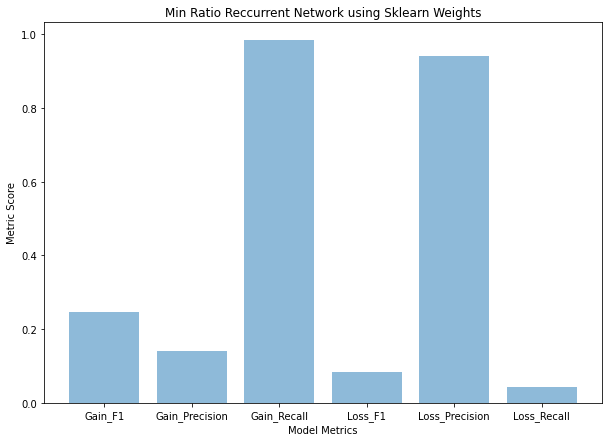

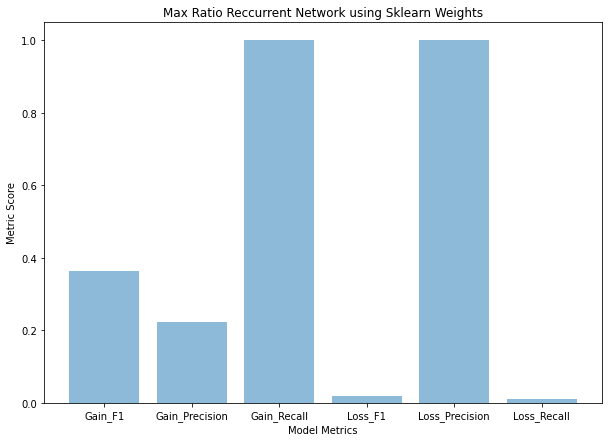

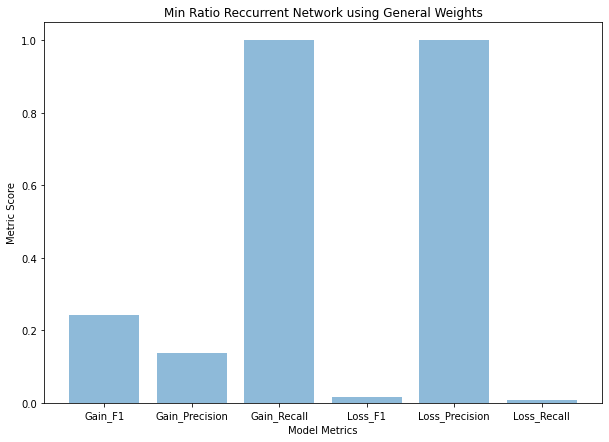

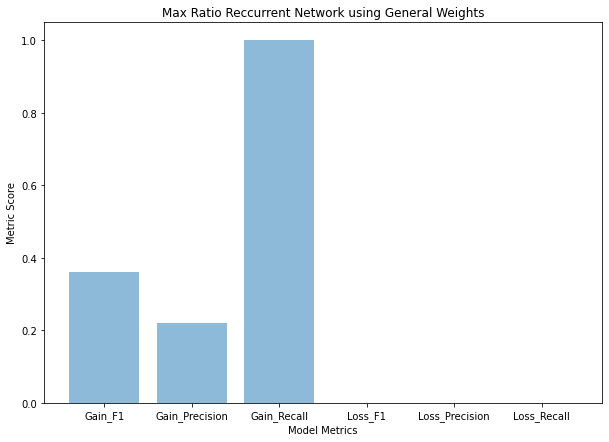

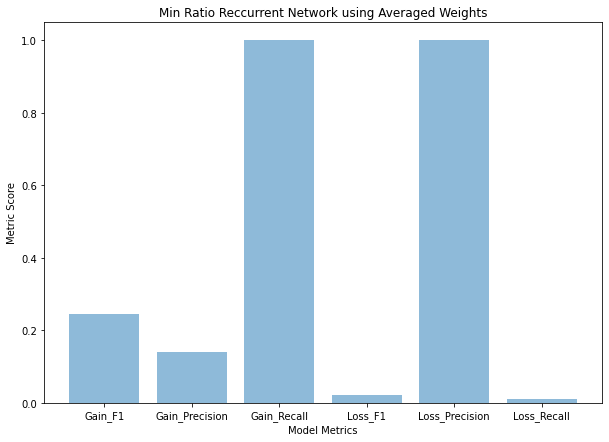

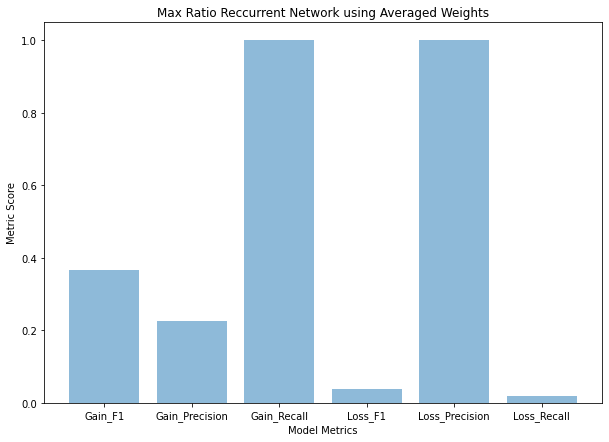

In [128]:
# 0 = sklearn weights
# 1 = general weights
# 2 = averaged weights
counter = 0
for (min, max) in zip (min_model_metrics, max_model_metrics):
  if counter == 0:
    w = 'Sklearn Weights'
  if counter == 1:
    w = 'General Weights'
  if counter == 2:
    w = 'Averaged Weights'
  
  plot_classification_report(min, 'Min Ratio Reccurrent Network using '+w, 
                             labels=int)
  plot_classification_report(max, 'Max Ratio Reccurrent Network using '+w, 
                             labels=int)
  counter += 1

## Best Model for news classification

# Conclusions

1. Develop & Patent NLP process to further understand stock news. Spend equal resources on processing text & body.

2. Class imbalance should be dealth with in the following way, ratios on the lower end of the spectrum e.g. < 8 should use skearn generated weights. While, class imbalance rations on the higher end < 8 should use the average weight between sklearn and the general forumula loss/gain.

3. Transformers models are the best in class for Natural Lanugage Processing, when developing models use a vanillas transformer as the baseline to ensure product value.

# Further Work
#### Provided with more time, I would....

- Further develop transformer model
  - Parameter Optimization
  - Add weights
- Develop business product capable of analyzing stock sentiment to enhance company & customer return on investment
- Develop custom filtering methods capable of determining:
  - Optimal weights for class imbalance
  - Trending stocks (positive or negative)
- Develop process that collect equal gain & loss metrics so that models have higher performance
